In [4]:
import pandas as pd
from geopy.geocoders import Nominatim
import datetime

from scipy.spatial import distance
from math import sin, cos, sqrt, atan2, radians
import time
import shapely

from shapely.geometry import shape, Point
import shapely.wkt

import random

import regex as re

# Google Drive Data Folder
Any data that's not available in the repository `data` folder can be found [this Google Drive folder](https://drive.google.com/drive/folders/1JsxNW6hqSInCaDFb5RAN6UfVsiBRKuox?usp=sharing).

# Permits Data

In [5]:
permits = pd.read_csv('../data_large_sets/DOB_Permit_Issuance.csv')

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_922/4067808049.py:1: DtypeWarning: Columns (8,9,10,15,31,33,36,47,48,49,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  permits = pd.read_csv('../data_large_sets/DOB_Permit_Issuance.csv')


I downloaded this data on August 2, 2022. It's updated daily, so my work is current through that date.

In [3]:
permits.columns

Index(['BOROUGH', 'Bin #', 'House #', 'Street Name', 'Job #', 'Job doc. #',
       'Job Type', 'Self_Cert', 'Block', 'Lot', 'Community Board', 'Zip Code',
       'Bldg Type', 'Residential', 'Special District 1', 'Special District 2',
       'Work Type', 'Permit Status', 'Filing Status', 'Permit Type',
       'Permit Sequence #', 'Permit Subtype', 'Oil Gas', 'Site Fill',
       'Filing Date', 'Issuance Date', 'Expiration Date', 'Job Start Date',
       'Permittee's First Name', 'Permittee's Last Name',
       'Permittee's Business Name', 'Permittee's Phone #',
       'Permittee's License Type', 'Permittee's License #',
       'Act as Superintendent', 'Permittee's Other Title', 'HIC License',
       'Site Safety Mgr's First Name', 'Site Safety Mgr's Last Name',
       'Site Safety Mgr Business Name', 'Superintendent First & Last Name',
       'Superintendent Business Name', 'Owner's Business Type', 'Non-Profit',
       'Owner's Business Name', 'Owner's First Name', 'Owner's Last Name',
 

In [3]:
permits.head()

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,BRONX,2097114,265,EAST 161ST STREET,220411793,2,A2,N,2444.0,1.0,...,NaN,NaN,2123860481.0,05/10/2022 00:00:00,3905783,40.825928,-73.919514,16.0,18302.0,East Concourse-Concourse Village
1,QUEENS,4114282,41-17,MAIN STREET,421692010,2,A2,N,5043.0,11.0,...,NaN,NaN,7183912934.0,05/10/2022 00:00:00,3905784,40.757784,-73.829252,20.0,853.0,Flushing
2,BRONX,2092754,875,TAYLOR AVENUE,220585230,1,A2,N,3637.0,1.0,...,NaN,NaN,2123066936.0,05/10/2022 00:00:00,3905785,40.823072,-73.863399,18.0,42.0,Soundview-Castle Hill-Clason Point-Harding Park
3,BROOKLYN,3185962,161,BAY 35TH ST,340843671,1,A2,Y,6875.0,13.0,...,NaN,NaN,3478738710.0,05/10/2022 00:00:00,3905786,40.596642,-73.993310,47.0,302.0,Bensonhurst East
4,BRONX,2082461,258,CITY ISLAND AVENUE,220657331,1,A2,Y,5642.0,11.0,...,NaN,NaN,2123272277.0,05/10/2022 00:00:00,3905787,40.845730,-73.785907,13.0,516.0,Pelham Bay-Country Club-City Island


In [4]:
permits.shape

(3909190, 60)

## Reducing Columns

There are far more columns than I need. [The NYC Data page for DOB Permits](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a) has a list of columns.

I opted to get rid of most columns now. I kept `job #` to enable reconnecting additional data. I also cleaned up the column names.

I dropped `council_district` and `census_tract` at this point. I'm not using the former and I update the latter to 2020 Census tracts for uniformity and to connect to the demographic data for that census.

In [5]:
permits = permits[['BOROUGH', 'Bin #', 'House #', 'Street Name', 'Job #','Job Type', 
                   'Zip Code', 'Bldg Type', 'Residential', 'Work Type', 'Permit Status', 
                   'Filing Status', 'Permit Type', 'Permit Sequence #', 'Filing Date', 'Issuance Date', 'Expiration Date', 'Job Start Date', "Owner's Business Type", 
                   "Non-Profit", 'DOBRunDate', 'PERMIT_SI_NO', 'LATITUDE', 'LONGITUDE']]

In [6]:
permits.head()

,BOROUGH,Bin #,House #,Street Name,Job #,Job Type,Zip Code,Bldg Type,Residential,Work Type,...,Filing Date,Issuance Date,Expiration Date,Job Start Date,Owner's Business Type,Non-Profit,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE
0,BRONX,2097114,265,EAST 161ST STREET,220411793,A2,10451.0,2.0,NaN,MH,...,05/09/2022,05/09/2022,05/01/2023,05/27/2016,OTHER GOV'T AGENCY,N,05/10/2022 00:00:00,3905783,40.825928,-73.919514
1,QUEENS,4114282,41-17,MAIN STREET,421692010,A2,11355.0,2.0,NaN,MH,...,05/09/2022,05/09/2022,05/01/2023,10/28/2021,NYC AGENCY,N,05/10/2022 00:00:00,3905784,40.757784,-73.829252
2,BRONX,2092754,875,TAYLOR AVENUE,220585230,A2,10473.0,2.0,YES,OT,...,05/09/2022,05/09/2022,11/27/2022,05/09/2022,NYCHA/HHC,N,05/10/2022 00:00:00,3905785,40.823072,-73.863399
3,BROOKLYN,3185962,161,BAY 35TH ST,340843671,A2,11214.0,1.0,YES,OT,...,05/09/2022,05/09/2022,04/27/2023,05/09/2022,INDIVIDUAL,N,05/10/2022 00:00:00,3905786,40.596642,-73.993310
4,BRONX,2082461,258,CITY ISLAND AVENUE,220657331,A2,10464.0,2.0,NaN,OT,...,05/09/2022,05/09/2022,05/01/2023,07/23/2018,INDIVIDUAL,N,05/10/2022 00:00:00,3905787,40.845730,-73.785907


In [7]:
permits.columns = permits.columns.str.replace("'", "").str.replace('#', 'no').str.replace(' ', '_').str.lower()

In [ ]:
permits_backup = permits.copy()

## Examining Null Values

In [8]:
permits.isna().sum()

borough                       0
bin_no                        0
house_no                      4
street_name                   4
job_no                        0
job_type                      0
zip_code                   1166
bldg_type                 57389
residential             2330686
work_type                698603
permit_status             11219
filing_status                 0
permit_type                   1
permit_sequence_no            0
filing_date                   1
issuance_date             19937
expiration_date           11399
job_start_date               10
owners_business_type     171472
non-profit               167207
dobrundate                    4
permit_si_no                  0
latitude                  11160
longitude                 11160
dtype: int64

## `residential` and `job_type` Columns
It appears that in the `residential` column, `NaN`s are not residential. I want to look only at residential building, so I eliminated the non-residential buildings.

After that, I'm looked at the `job_type` to reduce down to new buildings.

Here's a [useful explanation of job types](https://fontanarchitecture.com/alt-1-alt-2-nyc/). [This site](https://ownersrepny.com/2011/10/12/nyc-building-permits-what-does-nb-alteration-type-i-ii-iii-and-directive-14-mean/) has even more detail.

In [9]:
permits['residential'].value_counts(dropna = False)

NaN    2330686
YES    1578504
Name: residential, dtype: int64

In [10]:
permits['residential'].value_counts()[0]/permits.shape[0]

0.4037931131513178

In [11]:
permits = permits[permits['residential'] == 'YES']
permits.shape

(1578504, 24)

In [12]:
permits['job_type'].value_counts()

A2    668065
NB    448845
A1    306156
A3    155437
SG         1
Name: job_type, dtype: int64

In [ ]:
permits[permits['job_type']=='NB']/permits

New residential buildings are 11.5% of the total permits in the database.

In [13]:
permits = permits[permits['job_type']=='NB']
permits.shape

(448845, 24)

## `permit_type`
`permit_type` (mostly) corresponds to "Work Type Acronyms" on [the DOB acronym glossary page](https://www1.nyc.gov/site/buildings/dob/acronym-glossary.page) (not "Permit Type Acronyms" on the page, oddly enough). This [Permit Type and Status Code page](https://www1.nyc.gov/site/buildings/industry/permit-type-and-job-status-codes.page) has more information:

- NB = New Building
- EQ = Equipment
- PL = Plumbing
- FO = Foundation/Earthwork
- EW = Equipment Work

[This DOB webpage](https://www1.nyc.gov/site/buildings/property-or-business-owner/job-types-codes.page) also provides apparent permit type codes. It doesn't appear to line up as well with the data in this data set, but including it, just in case.

In [15]:
permits['permit_type'].value_counts(dropna = False)

NB    217407
EQ    103526
PL     93959
FO     33935
EW        18
Name: permit_type, dtype: int64

In [16]:
permits.shape

(448845, 24)

In [17]:
permits = permits[permits['permit_type'] == 'NB']

In [18]:
permits.shape

(217407, 24)

## `filing_status`
I want initial permits, to keep the kind of permit consistent.

In [21]:
permits['filing_status'].value_counts(dropna = False)

RENEWAL    135471
INITIAL     81936
Name: filing_status, dtype: int64

In [22]:
permits.shape

(217407, 24)

In [23]:
permits = permits[permits['filing_status'] == 'INITIAL']

In [24]:
permits.shape

(81936, 24)

## Examining Time
The permits are issued relatively quickly, for the most part. This likely reflects the process for building in New York City, which requires getting approval _before_ applying for a permit. At this point, I haven't found data on applications for approval, which would add a really interesting dimension to this project if/when I find it.

[This Fontan Architects articles](https://fontanarchitecture.com/building-a-new-home-in-nyc/) explains that the architect gets approval before the contractor(s) get permits. [This site](https://www.ny-engineers.com/agencies/dob-approval-and-design) describes the process similarly.

## `bdlg_type`
The `bldg_type` data is pretty nonsensical. I reached out to the city and got the reply that building type can be 1-family, 2-family, 3-family, or Other, but that doesn't appear to line up with what I'm finding with `residential`, `job_type`, and `permit_type` (all non-residential buildings should be 'other', presumably, and those numbers don't _seem_ to add up at this point. I'm operating on the assumption that the `residential` column is reliable and am using that. Time allowing, I'll review how the numbers line up in more depth.

The DOB has a [list of building classifications](https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html), but it's much broader than this.

In [128]:
permits_backup['bldg_type'].value_counts(dropna = False)

2.0    2908242
1.0     943559
NaN      57389
Name: Bldg Type, dtype: int64

In [ ]:
permits['bldg_type'].value_counts(dropna = False)

In [26]:
permits.drop(columns = 'bldg_type', inplace = True)

## `work_type`
This proved not to have any information that's of use.

In [30]:
permits['work_type'].value_counts(dropna = False)

NaN    81936
Name: work_type, dtype: int64

In [31]:
permits.drop(columns = 'work_type', inplace = True)

## `permit_status`
I just want to look at the `'ISSUED'` columns, just to be sure the focus is on buildings that were first started in this period. I drop the rows that have `NaN` for that column because I don't have any way to reliably interpolate that and hey represent only about .5% of my remaining data.

In [32]:
permits['permit_status'].value_counts(dropna = False)

ISSUED        79116
RE-ISSUED      2312
NaN             439
IN PROCESS       68
REVOKED           1
Name: permit_status, dtype: int64

In [33]:
permits['permit_status'].value_counts(dropna = False)[2]/permits.shape[0]

0.00535784026557313

In [36]:
permits = permits[permits['permit_status'] == 'ISSUED']

In [37]:
permits['permit_status'].value_counts()

ISSUED    79116
Name: permit_status, dtype: int64

## Taking Care of Duplicates
Because there can be multiple permits for each job (for different trades, etc.), I opted to keep the oldest instance of a permit for each `job_no` as I'm most interested in when the building started.

In [38]:
permits[permits.duplicated(subset = ['job_no'], keep = False)].shape

(5046, 22)

In [39]:
duplicated = permits[permits.duplicated(subset = ['job_no'], keep = False)]
duplicated.head()

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,...,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude
3597,BROOKLYN,3428769,346,BERGEN STREET,301779396,NB,11217.0,YES,ISSUED,INITIAL,...,06/23/2008,06/23/2008,11/10/2008,06/23/2008,CORPORATION,N,06/26/2020 00:00:00,1832324,40.682824,-73.980487
12955,BRONX,2127279,710,EAST 221 ST,220492615,NB,10467.0,YES,ISSUED,INITIAL,...,07/17/2020,07/17/2020,09/27/2020,07/17/2020,CORPORATION,N,07/20/2020 00:00:00,3775974,40.884776,-73.861399
13936,QUEENS,4623155,10-06,127 STREET,421912210,NB,11356.0,YES,ISSUED,INITIAL,...,04/07/2022,04/08/2022,10/25/2022,04/08/2022,INDIVIDUAL,N,04/09/2022 00:00:00,3902390,40.788177,-73.841016
14039,QUEENS,4151229,75-23,166 STREET,421714363,NB,11366.0,YES,ISSUED,INITIAL,...,05/02/2019,05/02/2019,09/30/2020,05/02/2019,PARTNERSHIP,N,07/29/2020 00:00:00,3629269,40.726578,-73.802796
14554,BROOKLYN,3198213,2033,E 17 STREET,321791290,NB,11229.0,YES,ISSUED,INITIAL,...,01/23/2020,01/23/2020,09/30/2020,01/23/2020,INDIVIDUAL,N,07/29/2020 00:00:00,3732878,40.600443,-73.954771


In [40]:
pd.set_option('display.max_columns', 22)

In [41]:
duplicated['job_start_date'] = pd.to_datetime(duplicated['job_start_date'])

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/1232839256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicated['job_start_date'] = pd.to_datetime(duplicated['job_start_date'])


In [42]:
duplicated.sort_values(by='job_start_date', inplace = True)

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/3323442690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicated.sort_values(by='job_start_date', inplace = True)


In [43]:
duplicated.sort_values(by='job_no', inplace = True)

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/2717639440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicated.sort_values(by='job_no', inplace = True)


In [44]:
duplicated.head()

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,permit_type,permit_sequence_no,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude
3336873,MANHATTAN,1085345,2556A,8 AVENUE,100134070,NB,10030.0,YES,ISSUED,INITIAL,NB,1,07/30/1993,07/30/1993,01/01/1994,1993-07-30,OTHER,N,05/09/2022 00:00:00,454968,40.817374,-73.945898
34435,MANHATTAN,1085345,2556A,8 AVENUE,100134070,NB,10030.0,YES,ISSUED,INITIAL,NB,1,1993-07-30,1993-07-30,1994-01-01,1993-07-30,OTHER,N,2017-11-03,346857,40.817374,-73.945898
16676,MANHATTAN,1085611,2572A,8 AVENUE,100134178,NB,10030.0,YES,ISSUED,INITIAL,NB,1,1992-12-29,1992-12-29,1994-01-01,1992-12-29,OTHER,N,2017-11-03,293450,40.817936,-73.945486
3221901,MANHATTAN,1085611,2572A,8 AVENUE,100134178,NB,10030.0,YES,ISSUED,INITIAL,NB,1,12/29/1992,12/29/1992,01/01/1994,1992-12-29,OTHER,N,05/09/2022 00:00:00,386074,40.817936,-73.945486
93826,MANHATTAN,1084483,2543,8 AVENUE,100134258,NB,10030.0,YES,ISSUED,INITIAL,NB,1,1994-01-28,1994-01-28,1995-01-01,1994-01-28,OTHER,N,2017-11-03,403623,40.817275,-73.945999


In [45]:
duplicated.drop_duplicates(subset = 'job_no', inplace = True)

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/1961017179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicated.drop_duplicates(subset = 'job_no', inplace = True)


In [46]:
duplicated.shape

(2523, 22)

In [47]:
permits.shape

(79116, 22)

In [48]:
permits.drop_duplicates(subset = 'job_no', keep = False, inplace= True)

In [49]:
permits.shape

(74070, 22)

In [50]:
permits = pd.concat([permits, duplicated])

In [51]:
permits.shape

(76593, 22)

## `issuance_date`
The `issuance_date` looks like it's got some formatting problems, but looking at the HUGE variety of dates, going back at least to 1990, this is something I'll want to explore in EDA. I'm dropping the `NaN`s in order to keep this column. It's going to eliminate about .3% of the current data.

In [53]:
#permits['issuance_date'].value_counts(dropna = False)

05/24/2004     114
05/28/1997      83
04/04/2007      79
04/07/1995      75
11/12/2003      75
              ... 
01/02/1990       1
12/02/2011       1
10/05/1990       1
12/05/2011       1
2018-04-17       1
Name: issuance_date, Length: 8535, dtype: int64

In [54]:
#permits['issuance_date'].value_counts(dropna = False)[0]/permits.shape[0]

0.0014883866671889076

In [55]:
#permits = permits[permits['issuance_date'].notnull()]

In [56]:
#permits.shape

(76593, 22)

## `owners_business_type`
The missing `owners_business_type` represents about .01%. I drop them because I want to look at that column in EDA.

In [57]:
permits['owners_business_type'].value_counts(dropna = False)

CORPORATION           34475
INDIVIDUAL            26305
PARTNERSHIP            8775
OTHER                  6293
HPD                     251
NYC AGENCY              172
CONDO/CO-OP             121
NaN                     117
OTHER GOV'T AGENCY       36
NYCHA/HHC                22
NYCHA                    17
NY STATE                  4
DOE                       2
HHC                       2
DCAS                      1
Name: owners_business_type, dtype: int64

In [58]:
permits['owners_business_type'].value_counts(dropna = False)[7]/permits.shape[0]

0.0015275547373780893

In [59]:
permits = permits[permits['owners_business_type'].notnull()]

In [60]:
permits.shape

(76476, 22)

## `zip_code`
I'm going to work from longitude and latitude. However, I'd like to be able to preserve my ability to reference addresses and zip codes. If the need arises, I can fill in missing zip codes. For now, I set the zipcode NaNs to 99999 as that's not a real zipcode.

In [63]:
permits[permits['zip_code'].isnull()].shape

(46, 22)

In [64]:
permits[permits['zip_code'].isnull()].head()

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,permit_type,permit_sequence_no,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude
4224,QUEENS,4620764,150-37,SULLIVAN DRIVE,421256492,NB,NaN,YES,ISSUED,INITIAL,NB,1,05/14/2019,05/14/2019,01/08/2020,05/14/2019,PARTNERSHIP,N,06/01/2022 00:00:00,2090592,NaN,NaN
8951,BROOKLYN,3428883,208,NOSTRAND AVENUE,321477709,NB,NaN,YES,ISSUED,INITIAL,NB,1,06/21/2022,06/24/2022,03/07/2023,06/24/2022,CORPORATION,N,06/25/2022 00:00:00,3912506,40.693031,-73.952108
472510,STATEN ISLAND,5835116,20,AVALON CT,500040074,NB,NaN,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,133339,NaN,NaN
477769,STATEN ISLAND,5835113,12,AVALON CT,500040154,NB,NaN,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,133798,NaN,NaN
517587,STATEN ISLAND,5835114,14,AVALON CT,500040056,NB,NaN,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,137468,NaN,NaN


In [65]:
permits.loc[permits['zip_code'].isnull(), 'zip_code'] = 99999

In [66]:
permits[permits['zip_code'].isnull()]

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,permit_type,permit_sequence_no,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude


In [67]:
permits[permits['zip_code'] == 99999].head()

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,permit_type,permit_sequence_no,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude
4224,QUEENS,4620764,150-37,SULLIVAN DRIVE,421256492,NB,99999.0,YES,ISSUED,INITIAL,NB,1,05/14/2019,05/14/2019,01/08/2020,05/14/2019,PARTNERSHIP,N,06/01/2022 00:00:00,2090592,NaN,NaN
8951,BROOKLYN,3428883,208,NOSTRAND AVENUE,321477709,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/21/2022,06/24/2022,03/07/2023,06/24/2022,CORPORATION,N,06/25/2022 00:00:00,3912506,40.693031,-73.952108
472510,STATEN ISLAND,5835116,20,AVALON CT,500040074,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,133339,NaN,NaN
477769,STATEN ISLAND,5835113,12,AVALON CT,500040154,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,133798,NaN,NaN
517587,STATEN ISLAND,5835114,14,AVALON CT,500040056,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,137468,NaN,NaN


In [68]:
permits.isnull().sum()

borough                   0
bin_no                    0
house_no                  0
street_name               0
job_no                    0
job_type                  0
zip_code                  0
residential               0
permit_status             0
filing_status             0
permit_type               0
permit_sequence_no        0
filing_date               0
issuance_date             0
expiration_date           0
job_start_date            0
owners_business_type      0
non-profit                0
dobrundate                0
permit_si_no              0
latitude                314
longitude               314
dtype: int64

## `latitude` and `longitude`

I used [this guide in stackoverflow](https://stackoverflow.com/a/69856510) in combination with [this article](https://towardsdatascience.com/geocode-with-python-161ec1e62b89) to write the code below to turn addresses into latitude and longitude data, to fill in as much of the missing data as possible.

In [73]:
no_long_lat = permits[permits['latitude'].isnull()]

In [74]:
no_long_lat.head()

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,permit_type,permit_sequence_no,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude
3272,BROOKLYN,3429238,31,PORTE PLAZA,321647811,NB,11222.0,YES,ISSUED,INITIAL,NB,1,05/26/2022,05/26/2022,05/26/2023,05/26/2022,INDIVIDUAL,N,05/27/2022 00:00:00,3908658,NaN,NaN
4224,QUEENS,4620764,150-37,SULLIVAN DRIVE,421256492,NB,99999.0,YES,ISSUED,INITIAL,NB,1,05/14/2019,05/14/2019,01/08/2020,05/14/2019,PARTNERSHIP,N,06/01/2022 00:00:00,2090592,NaN,NaN
30803,QUEENS,4052777,75-56,GRAND CENTRAL PKWY EXT,400091887,NB,11375.0,YES,ISSUED,INITIAL,NB,1,09/10/1992,09/10/1992,09/01/1993,09/10/1992,INDIVIDUAL,N,05/09/2022 00:00:00,39154,NaN,NaN
51877,QUEENS,4535350,10-47,BAY 32 STREET,400766220,NB,11691.0,YES,ISSUED,INITIAL,NB,1,05/15/1998,05/15/1998,02/14/1999,05/15/1998,CORPORATION,N,05/09/2022 00:00:00,1007397,NaN,NaN
105558,QUEENS,4459343,10-89,BAY 32 STREET,400766079,NB,11691.0,YES,ISSUED,INITIAL,NB,1,05/15/1998,05/15/1998,02/14/1999,05/15/1998,CORPORATION,N,05/09/2022 00:00:00,1007594,NaN,NaN


In [75]:
no_long_lat.shape

(314, 22)

In [76]:
no_long_lat.isnull().sum()

borough                   0
bin_no                    0
house_no                  0
street_name               0
job_no                    0
job_type                  0
zip_code                  0
residential               0
permit_status             0
filing_status             0
permit_type               0
permit_sequence_no        0
filing_date               0
issuance_date             0
expiration_date           0
job_start_date            0
owners_business_type      0
non-profit                0
dobrundate                0
permit_si_no              0
latitude                314
longitude               314
dtype: int64

In [77]:
no_long_lat[no_long_lat['zip_code'] == 99999].shape

(42, 22)

In [78]:
no_long_lat[no_long_lat['zip_code'] == 99999].head()

,borough,bin_no,house_no,street_name,job_no,job_type,zip_code,residential,permit_status,filing_status,permit_type,permit_sequence_no,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,permit_si_no,latitude,longitude
4224,QUEENS,4620764,150-37,SULLIVAN DRIVE,421256492,NB,99999.0,YES,ISSUED,INITIAL,NB,1,05/14/2019,05/14/2019,01/08/2020,05/14/2019,PARTNERSHIP,N,06/01/2022 00:00:00,2090592,NaN,NaN
472510,STATEN ISLAND,5835116,20,AVALON CT,500040074,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,133339,NaN,NaN
477769,STATEN ISLAND,5835113,12,AVALON CT,500040154,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,133798,NaN,NaN
517587,STATEN ISLAND,5835114,14,AVALON CT,500040056,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,137468,NaN,NaN
520547,STATEN ISLAND,5835115,16,AVALON CT,500040065,NB,99999.0,YES,ISSUED,INITIAL,NB,1,06/09/1993,06/09/1993,05/01/1994,06/09/1993,CORPORATION,N,05/09/2022 00:00:00,137741,NaN,NaN


In [79]:
no_long_lat['zip_code'].astype(int).astype(str)

3272       11222
4224       99999
30803      11375
51877      11691
105558     11691
           ...  
93905      11239
172607     11691
2089282    99999
3471768    99999
50908      99999
Name: zip_code, Length: 314, dtype: object

In [80]:
no_long_lat['address'] = no_long_lat['house_no'].replace(" ", "") + " " + no_long_lat['street_name'] + "," + "New York,NY," + no_long_lat['zip_code'].astype(int).astype(str)



/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/2138012618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_long_lat['address'] = no_long_lat['house_no'].replace(" ", "") + " " + no_long_lat['street_name'] + "," + "New York,NY," + no_long_lat['zip_code'].astype(int).astype(str)


In [81]:
pd.set_option('display.max_colwidth', 100)

In [83]:
no_long_lat['address'].head()

3272                    31 PORTE PLAZA,New York,NY,11222
4224             150-37 SULLIVAN DRIVE,New York,NY,99999
30803     75-56 GRAND CENTRAL PKWY EXT,New York,NY,11375
51877              10-47 BAY 32 STREET,New York,NY,11691
105558             10-89 BAY 32 STREET,New York,NY,11691
Name: address, dtype: object

In [88]:
geolocator = Nominatim(user_agent="myApp")

bad_addresses = []
for i in no_long_lat.index:
    try:
        geocode = geolocator.geocode(no_long_lat.loc[i, 'address'])
        no_long_lat.loc[i, 'latitude'] = geocode.latitude
        no_long_lat.loc[i, 'longitude'] = geocode.longitude
    except:
        bad_addresses.append(i)
        pass

In [92]:
len(no_long_lat)

314

In [90]:
len(bad_addresses)

168

In [93]:
no_long_lat.isnull().sum()

borough                   0
bin_no                    0
house_no                  0
street_name               0
job_no                    0
job_type                  0
zip_code                  0
residential               0
permit_status             0
filing_status             0
permit_type               0
permit_sequence_no        0
filing_date               0
issuance_date             0
expiration_date           0
job_start_date            0
owners_business_type      0
non-profit                0
dobrundate                0
permit_si_no              0
latitude                168
longitude               168
address                   0
dtype: int64

In [95]:
#pulling out the ones that now have long/lat
has_long_lat = no_long_lat[no_long_lat['latitude'].notnull()]
no_long_lat = no_long_lat[no_long_lat['latitude'].isnull()]

In [96]:
has_long_lat.shape

(146, 23)

In [97]:
no_long_lat.shape

(168, 23)

In [98]:
permits.shape

(76476, 22)

In [99]:
no_long_lat.shape[0]/permits.shape[0]

0.0021967676133689

In [100]:
permits = permits[permits['latitude'].notnull()]

In [101]:
permits.shape

(76162, 22)

In [255]:
#permits2 = permits.copy()

In [103]:
permits = pd.concat([permits, has_long_lat])

In [104]:
permits.shape

(76308, 23)

In [106]:
permits.drop(columns = ['address'], inplace = True)

In [107]:
permits.isnull().sum()

borough                 0
bin_no                  0
house_no                0
street_name             0
job_no                  0
job_type                0
zip_code                0
residential             0
permit_status           0
filing_status           0
permit_type             0
permit_sequence_no      0
filing_date             0
issuance_date           0
expiration_date         0
job_start_date          0
owners_business_type    0
non-profit              0
dobrundate              0
permit_si_no            0
latitude                0
longitude               0
dtype: int64

In [108]:
permits.to_csv('../backup_data/perms_backup1_added_geolocate.csv', index = False)

## More Cleaning
Before doing some more computing intensive cleaning, I clean some columns up here, then narrow the data set down to the timeframe I'd like.

After verifying the contents of `filing_stats`, `job_type`, and `permit_type` are what I expect, I drop 'job_type', 'residential', 'filing_status','permit_type','permit_si_no', 'permit_sequence_no' because I don't need them at this point and/or can't determine what they are (i.e. `permit_si_no`).

In [138]:
permits.shape

(76308, 22)

In [139]:
permits.columns

Index(['borough', 'bin_no', 'house_no', 'street_name', 'job_no', 'job_type',
       'zip_code', 'residential', 'permit_status', 'filing_status',
       'permit_type', 'permit_sequence_no', 'filing_date', 'issuance_date',
       'expiration_date', 'job_start_date', 'owners_business_type',
       'non-profit', 'dobrundate', 'permit_si_no', 'latitude', 'longitude'],
      dtype='object')

In [140]:
permits['filing_status'].value_counts()

INITIAL    76308
Name: filing_status, dtype: int64

In [141]:
permits['job_type'].value_counts()

NB    76308
Name: job_type, dtype: int64

In [142]:
permits['permit_type'].value_counts()

NB    76308
Name: permit_type, dtype: int64

In [143]:
permits.drop(columns = ['job_type', 'residential', 'filing_status','permit_type','permit_si_no', 'permit_sequence_no'], inplace = True)

In [144]:
permits.shape

(76308, 16)

make zip_code integer.
make filing_date, issuance_date, expiration_date, job_start_date into datetimes. Do I need expiration date?

what is permit_si_no? I can't find that anywhere online. Number for the permit? As opposed to the job?
permit_sequence_no?

can drop residential at this point because they're all residential. check it first to make sure.

Check the statuses to see what they look like

In [145]:
permits.dtypes

borough                  object
bin_no                    int64
house_no                 object
street_name              object
job_no                    int64
zip_code                float64
permit_status            object
filing_date              object
issuance_date            object
expiration_date          object
job_start_date           object
owners_business_type     object
non-profit               object
dobrundate               object
latitude                float64
longitude               float64
dtype: object

In [146]:
permits['zip_code'] = permits['zip_code'].astype(int)

In [147]:
permits['filing_date'] = pd.to_datetime(permits['filing_date'])

In [148]:
permits['issuance_date'] = pd.to_datetime(permits['issuance_date'])

In [149]:
permits['expiration_date'] = pd.to_datetime(permits['expiration_date'])

In [150]:
permits['job_start_date'] = pd.to_datetime(permits['job_start_date'])

In [151]:
permits['dobrundate'] = pd.to_datetime(permits['dobrundate'])

In [152]:
permits['expiration_date'] = pd.to_datetime(permits['expiration_date'])

In [153]:
permits.dtypes

borough                         object
bin_no                           int64
house_no                        object
street_name                     object
job_no                           int64
zip_code                         int64
permit_status                   object
filing_date             datetime64[ns]
issuance_date           datetime64[ns]
expiration_date         datetime64[ns]
job_start_date          datetime64[ns]
owners_business_type            object
non-profit                      object
dobrundate              datetime64[ns]
latitude                       float64
longitude                      float64
dtype: object

In [154]:
permits['job_start_date'].describe()

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/1807671964.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  permits['job_start_date'].describe()


count                   76308
unique                   7679
top       2004-05-24 00:00:00
freq                      116
first     1989-09-08 00:00:00
last      2217-10-23 00:00:00
Name: job_start_date, dtype: object

## 6 Years Back
I eliminatee data for jobs starting more than 6 years ago.

There were a handful of data that had problematic job start dates that were clearly from clerical errors. Most of those were from older permits than I'm interested and there were so few remaining I decided to eliminate those.

Working from `expiration_date` reveals 5 rows that clearly represent clerical errors.

In [155]:
permits = permits[permits['job_start_date']> pd.to_datetime('2016-08-02')]

In [156]:
permits[permits['job_start_date']>pd.to_datetime('2022-09-30')].shape

(10, 16)

In [157]:
permits.shape

(7187, 16)

In [158]:
permits[permits['expiration_date']<pd.to_datetime('2016-08-02')].shape

(5, 16)

In [159]:
permits[permits['expiration_date']<pd.to_datetime('2016-08-02')]

,borough,bin_no,house_no,street_name,job_no,zip_code,permit_status,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,latitude,longitude
20645,BROOKLYN,3387710,168,CLYMER STREET,301003027,11211,ISSUED,2002-10-17,2002-10-17,2003-08-14,2020-10-17,INDIVIDUAL,N,2022-05-09,40.706954,-73.963001
33274,QUEENS,4102779,151-38,7 AVENUE,402290588,11357,ISSUED,2006-08-04,2006-08-10,2007-03-07,2206-08-10,INDIVIDUAL,N,2022-05-09,40.795141,-73.812218
44460,BRONX,2128376,943,FTELEY AVE,220361935,10473,ISSUED,2014-09-02,2014-09-02,2015-06-03,2104-09-02,INDIVIDUAL,N,2022-05-09,40.823810,-73.870284
47400,BRONX,2102544,2082,HONEYWELL AVENUE,200614193,10460,ISSUED,2000-11-20,2000-11-20,2001-02-26,2200-11-20,PARTNERSHIP,N,2022-05-09,40.844549,-73.882785
69459,BROOKLYN,3388038,772,HERKIMER STREET,301467240,11233,ISSUED,2003-01-17,2003-01-17,2003-11-15,2030-01-17,CORPORATION,N,2022-05-09,40.678436,-73.927880


In [160]:
#eliminating these 5 rows
permits = permits[permits['expiration_date']>pd.to_datetime('2016-08-02')]

In [161]:
permits.shape

(7182, 16)

In [162]:
permits[permits['job_start_date']<pd.to_datetime('2022-09-30')].shape

(7176, 16)

### Late Job Start Dates
With one possible exception, it appears almost certain the `job_start_date` is meant to be  the same as the `issuance_date`. In the case of job no 440664504, it appears possible it's a typo from the issuance date and the current job start date is actually after the expiration. Ultimately, I decided to replace all these job start dates with the issuance date.
### NOTE
I did this after having done a lot of time consuming computation on a previous version of the data set, so these will likely be dropped in my analysis, but they're preserved if someone wants to recreate this analysis. It may lead to a slightly different outcome.

In [163]:
permits[permits['job_start_date']>pd.to_datetime('2022-09-30')]

,borough,bin_no,house_no,street_name,job_no,zip_code,permit_status,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,latitude,longitude
51309,BROOKLYN,3426514,221,MIDDLETON ST,321112862,11206,ISSUED,2017-10-23,2017-10-23,2018-10-04,2217-10-23,INDIVIDUAL,N,2022-05-09,40.704171,-73.949290
51313,STATEN ISLAND,5165138,398,PAGE AVENUE,520287010,10307,ISSUED,2017-10-23,2017-10-23,2018-10-17,2107-10-23,PARTNERSHIP,N,2022-05-09,40.514573,-74.232284
51706,BROOKLYN,3425205,436,FLUSHING AVENUE,321547215,11205,ISSUED,2017-12-13,2017-12-19,2018-12-19,2107-12-19,PARTNERSHIP,N,2022-05-09,40.698902,-73.957409
54763,BRONX,2816717,1167,VYSE AVENUE,220635212,10459,ISSUED,2020-08-12,2020-08-12,2021-01-25,2025-08-12,CORPORATION,N,2022-05-09,40.827879,-73.889965
56306,QUEENS,4163388,64-62,230 STREET,440664504,11364,ISSUED,2021-12-17,2022-01-28,2022-07-31,2022-12-18,INDIVIDUAL,N,2022-05-09,40.749181,-73.747600
56983,STATEN ISLAND,5171643,265,YORK AVENUE,520228584,10301,ISSUED,2019-01-17,2019-01-17,2020-01-06,2109-01-17,INDIVIDUAL,N,2022-05-09,40.639924,-74.088026


In [164]:
fixed_job_dates = permits[permits['job_start_date']>pd.to_datetime('2022-09-30')]['job_no'].to_list()

In [165]:
fixed_job_dates

[321112862, 520287010, 321547215, 220635212, 440664504, 520228584]

In [171]:
for i in permits[permits['job_start_date']>pd.to_datetime('2022-09-30')].index:
    permits.loc[i, 'job_start_date'] = permits.loc[i,'issuance_date']


In [172]:
permits[permits['job_start_date']>pd.to_datetime('2022-09-30')]

,borough,bin_no,house_no,street_name,job_no,zip_code,permit_status,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,latitude,longitude


In [173]:
permits.shape

(7182, 16)

### Checking That Expiration Date and Job Start Date Are Reasonable
I wanted to screen out other possible transcription error. I looked at the time between job_start_date and expiration. I can't find information online about how long before permits expire, typically, but none of the periods seem unreasonable, as they all fall within 2 years of the job_start_date, so I left them as is

[This stackoverflow answer](https://stackoverflow.com/a/37588991) helped me understand how to use .days to get the number of days.

In [174]:
permits['difference'] = permits['expiration_date']-permits['job_start_date']
permits['difference'] = permits['difference'].map(lambda x: x.days)
permits['difference'].head()

1    365
2    365
3    288
4    344
5    365
Name: difference, dtype: int64

In [175]:
permits[permits['difference'] > 550]

,borough,bin_no,house_no,street_name,job_no,zip_code,permit_status,filing_date,issuance_date,expiration_date,job_start_date,owners_business_type,non-profit,dobrundate,latitude,longitude,difference
36113,BROOKLYN,3171499,1169,EAST 9 STREET,321770810,11230,ISSUED,2019-05-24,2019-05-28,2021-01-31,2019-05-28,INDIVIDUAL,N,2022-05-09,40.620648,-73.966345,614
41055,QUEENS,4201081,101-64,132 STREET,421415686,11419,ISSUED,2019-04-11,2019-04-11,2020-10-31,2019-04-11,NYCHA/HHC,N,2022-05-09,40.691674,-73.814738,569
41434,QUEENS,4026146,32-11,60 STREET,421717100,11377,ISSUED,2019-05-17,2019-05-22,2020-11-30,2019-05-22,INDIVIDUAL,N,2022-05-09,40.755452,-73.902408,558
41438,QUEENS,4548904,32-15,60 STREET,421717155,11377,ISSUED,2019-05-17,2019-05-22,2020-11-30,2019-05-22,INDIVIDUAL,N,2022-05-09,40.755391,-73.902397,558
42424,QUEENS,4619476,31-17,37TH ST,420664597,11103,ISSUED,2019-05-08,2019-05-08,2020-11-30,2019-05-08,CORPORATION,N,2022-05-09,40.761448,-73.919181,572
43318,BRONX,2129024,957,TILDEN ST,210177921,10469,ISSUED,2019-03-27,2019-03-27,2020-09-30,2019-03-27,INDIVIDUAL,N,2022-05-09,40.876821,-73.858059,553
45778,QUEENS,4258336,147-48,FERNDALE AVE,421713596,11435,ISSUED,2019-05-22,2019-05-22,2020-11-30,2019-05-22,CORPORATION,N,2022-05-09,40.690615,-73.798673,558
51369,BROOKLYN,3172842,1466,EAST 5TH ST,321636002,11230,ISSUED,2019-04-12,2019-04-12,2020-10-31,2019-04-12,INDIVIDUAL,N,2022-05-09,40.615182,-73.970177,568
52338,BROOKLYN,3426084,1,CROSBY AVENUE,320912599,11207,ISSUED,2019-06-12,2019-06-12,2020-12-31,2019-06-12,CORPORATION,N,2022-05-09,40.681681,-73.896051,568
53342,BROOKLYN,3131942,2042,59 STREET,321926751,11204,ISSUED,2019-06-27,2019-06-27,2020-12-31,2019-06-27,CORPORATION,N,2022-05-09,40.619318,-73.981229,553


### Further Reducing Columns
At this point, I don't need a number of the remaining columns.

In [177]:
permits.columns

Index(['borough', 'bin_no', 'house_no', 'street_name', 'job_no', 'zip_code',
       'permit_status', 'filing_date', 'issuance_date', 'expiration_date',
       'job_start_date', 'owners_business_type', 'non-profit', 'dobrundate',
       'latitude', 'longitude', 'difference'],
      dtype='object')

In [178]:
permits = permits[['borough', 'bin_no', 'house_no', 'street_name', 'job_no', 'zip_code',
       'job_start_date', 'owners_business_type', 'non-profit',
       'latitude', 'longitude']]

In [179]:
permits.shape

(7182, 11)

In [182]:
permits.to_csv('../backup_data/perms_backup_2_columns_cleaned.csv', index = False)

In [193]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721


In [200]:
#doing this at this point to be sure the work I do with the new index is preserved.
permits.reset_index(inplace = True, drop = True)

In [201]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721


## Are they in NYC?
A mapping of this data revealed that some of these points actually aren't in NYC. I suspect the longitude and latitude are wrong and that these data points could be restored using their addresses, but given the time frame I'm working on, I need to save the time and just eliminate them. I do this here to make sure there aren't any permits that won't be in NYC census tracts when we get to those.

In [6]:
boundaries = pd.read_csv('../data_large_sets/nybb.csv')
boundaries.head()

,the_geom,BoroCode,BoroName,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-73.82644661516991 40.59052744...,4,Queens,900269.280485,3.040206e+09
1,MULTIPOLYGON (((-73.86327471071958 40.58387684...,3,Brooklyn,728477.954082,1.934167e+09
2,MULTIPOLYGON (((-74.05050806403247 40.56642203...,5,Staten Island,325924.002076,1.623631e+09
3,MULTIPOLYGON (((-74.01092841268031 40.68449147...,1,Manhattan,359993.126318,6.366208e+08
4,MULTIPOLYGON (((-73.89680883223778 40.79580844...,2,Bronx,463868.599917,1.187194e+09


In [184]:
def shape_list(multipolygons):
    shape_list = []
    for i in range(0, len(multipolygons)):
        name = f'shape{i}'
        name = shapely.wkt.loads(multipolygons[i])
        shape_list.append(name)
    return shape_list

In [185]:
boroughs_shapes = shape_list(boundaries['the_geom'])

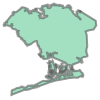

In [186]:
boroughs_shapes[0]

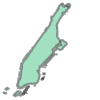

In [187]:
boroughs_shapes[3]

## Getting Points Into Permits DF
The point enables us to examine the borough and the census tract.

In [204]:
permits.loc[0, 'point'] = ''

In [205]:
for i in permits.index:
    permits.loc[i, 'point'] = shapely.geometry.Point(permits.loc[i, 'longitude'], permits.loc[i, 'latitude'])

/Users/lorendunn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:304: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  applied = getattr(b, f)(**kwargs)


In [207]:
#this establishes default 'no' that is necessary to the if statement below.
permits['in_nyc'] = 0

In [208]:
t0 = time.time()

for i in range(0, len(boroughs_shapes)):
    print(i)
    t1 = time.time()
    shape = boroughs_shapes[i]
    minx, miny, maxx, maxy = shape.bounds
    bounding_box = shapely.geometry.box(minx, miny, maxx, maxy)
    for n in permits.index:
        if permits.loc[n, 'in_nyc'] == 0:
            point = permits.loc[n, 'point']
            if bounding_box.contains(point):
                if shape.contains(point):
                    permits.loc[n, 'in_nyc'] = 1
                    permits.loc[n, 'in_borough'] = boundaries.loc[i, 'BoroName'].upper()
    print(f"Time from start to end of {i} loop: {time.time()-t0}")
    print(f"Time to run the {i} loop: {time.time()-t1}")
    print('')
print(f"Total time: {time.time()-t0}")

0
Time from start to end of 0 loop: 19.690491914749146
Time to run the 0 loop: 19.689712047576904

1
Time from start to end of 1 loop: 27.036584854125977
Time to run the 1 loop: 7.346374034881592

2
Time from start to end of 2 loop: 28.8727068901062
Time to run the 2 loop: 1.8357861042022705

3
Time from start to end of 3 loop: 29.431148767471313
Time to run the 3 loop: 0.5584099292755127

4
Time from start to end of 4 loop: 30.9141628742218
Time to run the 4 loop: 1.482985019683838

Total time: 30.914707899093628


In [209]:
permits['in_nyc'].value_counts()

1    7174
0       8
Name: in_nyc, dtype: int64

In [210]:
out_of_nyc = permits[permits['in_nyc'] == 0]['job_no'].to_list()

In [211]:
out_of_nyc

[420663712,
 420663589,
 420858405,
 520363071,
 520363080,
 520363099,
 420663570,
 420667558]

In [212]:
permits = permits[permits['in_nyc'] == 1]

## Confirming That Search Identified Same Borough As the Original Data Frame
All of them match.

In [213]:
permits.shape

(7174, 14)

In [214]:
permits[(permits['in_borough'] == permits['borough'])].shape

(7174, 14)

In [215]:
permits[(permits['in_borough'] != permits['borough'])].shape

(0, 14)

## Census Tract and Council District in Permits
This [NYC Data page](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Mapped/weqx-t5xr) has 2020 Census Tracts.

Census tracts change over time, so I'm using 2020 Census tracts for all the permits.

In [7]:
census_tracts = pd.read_csv('../data_large_sets/2020_Census_Tracts_-_Tabular.csv')

In [8]:
census_tracts.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1.00,1,Manhattan,100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,MULTIPOLYGON (((-73.98449647076764 40.70950966...,2.01,1,Manhattan,201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495250,9.723121e+05
2,MULTIPOLYGON (((-73.98237340572007 40.70554335...,2.02,1,Manhattan,202,1000202,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000202,8568.089429,3.315114e+06
3,MULTIPOLYGON (((-74.01092841268031 40.68449147...,5.00,1,Manhattan,500,1000500,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000500,32642.083745,9.083214e+06
4,MULTIPOLYGON (((-73.99022012669926 40.71440493...,6.00,1,Manhattan,600,1000600,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06


In [218]:
census_tracts.columns = census_tracts.columns.str.lower()

### Building Census Tract Shapes

In [219]:
def shape_list(multipolygons):
    shape_list = []
    for i in range(0, len(multipolygons)):
        name = f'shape{i}'
        name = shapely.wkt.loads(multipolygons[i])
        shape_list.append(name)
    return shape_list

In [220]:
census_shapes = shape_list(census_tracts['the_geom'])

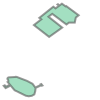

In [221]:
census_shapes[0]

In [389]:
#no_census_tract = permits[permits['census_tract'].isnull()]

In [390]:
#no_census_tract.shape

(80, 15)

### Determine What Data I Need From Census Tract to be able to Match With Socioeconomic Data
At this point I needed to identify the proper label for the census track in order to be able to pull that into the permits dataframe, for later matching with demographic information.

I found the 2020 Census Data at this [NYC Planning site](https://www1.nyc.gov/site/planning/planning-level/nyc-population/2020-census.page#2020-census-data-resource), through the 2020 Census Data link, which provides an [automatic download of the data](https://www1.nyc.gov/assets/planning/download/office/planning-level/nyc-population/census2020/nyc_decennialcensusdata_2010_2020_change.xlsx?r=3).

The relevant label is `bct2020` in the census_data dataframe, `boroct2020` in the census_tract dataframe. These initials stand for 'Borough Census Tract' 2020.

The data dictionary for the census_data is in the `data_large_sets` folder found at [this Google Drive link](https://drive.google.com/drive/folders/1JsxNW6hqSInCaDFb5RAN6UfVsiBRKuox?usp=sharing).

In [9]:
census_data = pd.read_csv('../data_large_sets/census_tract_data2020.csv')

In [223]:
census_data.columns = census_data.columns.str.lower()

In [224]:
census_data.head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,...,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",100.0,27,0.7,"3,745",99.3,"3,745",...,1.6,12,0.3,10,0.3,1,100.0,0,NaN,1,100.0
1,CT2020,Bronx,36005000200,2000200,"4,779",100.0,"4,771",99.8,8,0.2,0,...,4.2,115,2.4,126,2.6,"1,594",100.0,"1,517",95.2,77,4.8
2,CT2020,Bronx,36005000400,2000400,"6,272",100.0,"6,258",99.8,14,0.2,0,...,3.7,91,1.5,149,2.4,"2,200",100.0,"2,110",95.9,90,4.1
3,CT2020,Bronx,36005001600,2001600,"5,795",100.0,"5,565",96.0,230,4.0,205,...,2.1,81,1.4,108,1.9,"2,129",100.0,"2,042",95.9,87,4.1
4,CT2020,Bronx,36005001901,2001901,"2,292",100.0,"2,258",98.5,34,1.5,0,...,1.7,35,1.5,76,3.3,"1,049",100.0,988,94.2,61,5.8


In [225]:
permits['bct2020'] = ''

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_1191/2114652089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permits['bct2020'] = ''


In [226]:
t0 = time.time()

for i in range(0, len(census_shapes)):
    print(i)
    t1 = time.time()
    shape = census_shapes[i]
    minx, miny, maxx, maxy = shape.bounds
    bounding_box = shapely.geometry.box(minx, miny, maxx, maxy)
    for n in permits.index:
        if permits.loc[n, 'bct2020'] == '':
            point = permits.loc[n, 'point']
            if bounding_box.contains(point):
                if shape.contains(point):
                    permits.loc[n, 'bct2020'] = census_tracts['boroct2020'][i]
    print(f"Time from start to end of {i} loop: {time.time()-t0}")
    print(f"Time to run the {i} loop: {time.time()-t1}")
    print('')
print(f"Total time: {time.time()-t0}")

0
Time from start to end of 0 loop: 0.1333310604095459
Time to run the 0 loop: 0.13265109062194824

1
Time from start to end of 1 loop: 0.23665094375610352
Time to run the 1 loop: 0.1032419204711914

2
Time from start to end of 2 loop: 0.33852195739746094
Time to run the 2 loop: 0.10187506675720215

3
Time from start to end of 3 loop: 0.4363858699798584
Time to run the 3 loop: 0.0977320671081543

4
Time from start to end of 4 loop: 0.5432190895080566
Time to run the 4 loop: 0.106964111328125

5
Time from start to end of 5 loop: 0.6439268589019775
Time to run the 5 loop: 0.10057187080383301

6
Time from start to end of 6 loop: 0.7494361400604248
Time to run the 6 loop: 0.10564708709716797

7
Time from start to end of 7 loop: 0.850665807723999
Time to run the 7 loop: 0.1010582447052002

8
Time from start to end of 8 loop: 0.9515728950500488
Time to run the 8 loop: 0.10085487365722656

9
Time from start to end of 9 loop: 1.0559229850769043
Time to run the 9 loop: 0.10435104370117188

10
T

I'll take more look at this in EDA, but I wanted to see if these make sense

In [227]:
permits['bct2020'].value_counts()

4091603    150
5011203    146
3107001     94
5019800     81
5022601     72
          ... 
1018600      1
3057000      1
4025500      1
3050801      1
4067900      1
Name: bct2020, Length: 1401, dtype: int64

In [228]:
len(permits['bct2020'].unique())

1401

Confirming no nulls.

In [230]:
permits.isnull().sum()

borough                 0
bin_no                  0
house_no                0
street_name             0
job_no                  0
zip_code                0
job_start_date          0
owners_business_type    0
non-profit              0
latitude                0
longitude               0
point                   0
in_nyc                  0
in_borough              0
bct2020                 0
dtype: int64

# Exporting Cleaned Permits

In [233]:
permits.to_csv('data/cleaned_permits.csv', index = False)

-----

# Cleaning Census Data

All the null data are percentages. Every row has at least 1 null column.

In [10]:
census_data = pd.read_csv('../data_large_sets/census_tract_data2020.csv')

In [309]:
census_data.columns = census_data.columns.str.lower()

In [310]:
census_data.head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,avhhsz_20p,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",100.0,27,0.7,"3,745",99.3,"3,745",99.3,NaN,NaN,12,0.3,"1,259",33.4,260,6.9,"2,172",57.6,59,1.6,12,0.3,10,0.3,1,100.0,0,NaN,1,100.0
1,CT2020,Bronx,36005000200,2000200,"4,779",100.0,"4,771",99.8,8,0.2,0,NaN,3.15,NaN,"1,065",22.3,"3,173",66.4,152,3.2,"1,011",21.2,202,4.2,115,2.4,126,2.6,"1,594",100.0,"1,517",95.2,77,4.8
2,CT2020,Bronx,36005000400,2000400,"6,272",100.0,"6,258",99.8,14,0.2,0,NaN,2.97,NaN,"1,337",21.3,"3,972",63.3,238,3.8,"1,592",25.4,230,3.7,91,1.5,149,2.4,"2,200",100.0,"2,110",95.9,90,4.1
3,CT2020,Bronx,36005001600,2001600,"5,795",100.0,"5,565",96.0,230,4.0,205,3.5,2.73,NaN,"1,251",21.6,"3,479",60.0,121,2.1,"1,884",32.5,122,2.1,81,1.4,108,1.9,"2,129",100.0,"2,042",95.9,87,4.1
4,CT2020,Bronx,36005001901,2001901,"2,292",100.0,"2,258",98.5,34,1.5,0,NaN,2.29,NaN,567,24.7,"1,089",47.5,250,10.9,803,35.0,39,1.7,35,1.5,76,3.3,"1,049",100.0,988,94.2,61,5.8


In [311]:
census_data.shape

(2327, 34)

In [312]:
census_data.dtypes

geotype        object
borough        object
geoid           int64
bct2020         int64
pop_20         object
pop_20p       float64
hhpop_20       object
hhpop_20p     float64
gq_20          object
gq_20p        float64
instgq_20      object
instgq_20p    float64
avhhsz_20     float64
avhhsz_20p    float64
popu18_20      object
popu18_20p    float64
hsp_20         object
hsp_20p       float64
wnh_20         object
wnh_20p       float64
bnh_20         object
bnh_20p       float64
anh_20         object
anh_20p       float64
onh_20         object
onh_20p       float64
nh2pl_20        int64
nh2pl_20p     float64
hunits_20      object
hunits_20p    float64
ochu_20        object
ochu_20p      float64
vachu_20       object
vachu_20p     float64
dtype: object

In [313]:
census_data.isnull().sum()

geotype          0
borough          0
geoid            0
bct2020          0
pop_20           0
pop_20p         35
hhpop_20         0
hhpop_20p       43
gq_20            0
gq_20p         787
instgq_20        0
instgq_20p    2034
avhhsz_20       57
avhhsz_20p    2327
popu18_20        0
popu18_20p      45
hsp_20           0
hsp_20p         48
wnh_20           0
wnh_20p         66
bnh_20           0
bnh_20p         70
anh_20           0
anh_20p         83
onh_20           0
onh_20p         87
nh2pl_20         0
nh2pl_20p       56
hunits_20        0
hunits_20p      38
ochu_20          0
ochu_20p        57
vachu_20         0
vachu_20p       75
dtype: int64

In [314]:
pd.set_option('display.max_columns', None)

In [315]:
census_data[census_data.isnull().any(axis = 1)]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,avhhsz_20p,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",100.0,27,0.7,"3,745",99.3,"3,745",99.3,NaN,NaN,12,0.3,"1,259",33.4,260,6.9,"2,172",57.6,59,1.6,12,0.3,10,0.3,1,100.0,0,NaN,1,100.0
1,CT2020,Bronx,36005000200,2000200,"4,779",100.0,"4,771",99.8,8,0.2,0,NaN,3.15,NaN,"1,065",22.3,"3,173",66.4,152,3.2,"1,011",21.2,202,4.2,115,2.4,126,2.6,"1,594",100.0,"1,517",95.2,77,4.8
2,CT2020,Bronx,36005000400,2000400,"6,272",100.0,"6,258",99.8,14,0.2,0,NaN,2.97,NaN,"1,337",21.3,"3,972",63.3,238,3.8,"1,592",25.4,230,3.7,91,1.5,149,2.4,"2,200",100.0,"2,110",95.9,90,4.1
3,CT2020,Bronx,36005001600,2001600,"5,795",100.0,"5,565",96.0,230,4.0,205,3.5,2.73,NaN,"1,251",21.6,"3,479",60.0,121,2.1,"1,884",32.5,122,2.1,81,1.4,108,1.9,"2,129",100.0,"2,042",95.9,87,4.1
4,CT2020,Bronx,36005001901,2001901,"2,292",100.0,"2,258",98.5,34,1.5,0,NaN,2.29,NaN,567,24.7,"1,089",47.5,250,10.9,803,35.0,39,1.7,35,1.5,76,3.3,"1,049",100.0,988,94.2,61,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,CT2020,Staten Island,36085030302,5030302,"6,669",100.0,"6,649",99.7,20,0.3,0,NaN,3.32,NaN,"1,532",23.0,"2,306",34.6,"1,622",24.3,"1,284",19.3,"1,219",18.3,80,1.2,158,2.4,"2,096",100.0,"2,001",95.5,95,4.5
2323,CT2020,Staten Island,36085031901,5031901,"3,262",100.0,"3,248",99.6,14,0.4,0,NaN,3.01,NaN,988,30.3,"1,218",37.3,179,5.5,"1,526",46.8,181,5.5,30,0.9,128,3.9,"1,122",100.0,"1,080",96.3,42,3.7
2324,CT2020,Staten Island,36085031902,5031902,"5,500",100.0,"5,459",99.3,41,0.7,7,0.1,3.09,NaN,"1,717",31.2,"1,722",31.3,472,8.6,"2,904",52.8,111,2.0,85,1.5,206,3.7,"1,864",100.0,"1,769",94.9,95,5.1
2325,CT2020,Staten Island,36085032300,5032300,"1,233",100.0,"1,233",100.0,0,NaN,0,NaN,2.67,NaN,285,23.1,454,36.8,205,16.6,415,33.7,80,6.5,24,1.9,55,4.5,498,100.0,461,92.6,37,7.4


Average Household Size Percent (`avhhsz_20p`) is seems nonsensical to me and is entirely NaN. As I'd rather work from the average household size itself, anyway, I'm dropping this.

In [316]:
census_data.drop(columns = 'avhhsz_20p', inplace = True)

The next largest number of nulls appears in `instgq_20p`. This is the percent institutionalize population. It appears to only appear when the institutional population is 0, and thus should be 0. 

In [317]:
census_data[(census_data['instgq_20p'].isnull()) & (census_data['instgq_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [318]:
for i in census_data[census_data['instgq_20p'].isnull()].index:
    census_data.loc[i, 'instgq_20p'] = 0

I look at the remaining nulls in the same light to see if they too are meant to be 0 

In [319]:
census_data[(census_data['gq_20p'].isnull()) & (census_data['gq_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [320]:
for i in census_data[census_data['gq_20p'].isnull()].index:
    census_data.loc[i, 'gq_20p'] = 0

There are a number of census tracts that are empty. I keep them just in case a random point lands in them from my test of the model. It's possible something in the permits set is in there too, but I'm keeping them, regardless

In [321]:
len(census_data[(census_data['pop_20p'].isnull()) & (census_data['pop_20'] == '0')])

35

In [322]:
census_data[(census_data['pop_20p'].isnull()) & (census_data['pop_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [323]:
census_data[(census_data['pop_20p'].isnull()) & (census_data['pop_20'] == '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
7,CT2020,Bronx,36005001904,2001904,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
69,CT2020,Bronx,36005011000,2011000,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
72,CT2020,Bronx,36005011702,2011702,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
360,CT2020,Bronx,36005051602,2051602,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
375,CT2020,Brooklyn,36047001804,3001804,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
383,CT2020,Brooklyn,36047003102,3003102,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
404,CT2020,Brooklyn,36047005303,3005303,0,NaN,0,NaN,0,0.0,0,0.0,0.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,69,100.0,2,2.9,67,97.1
432,CT2020,Brooklyn,36047008600,3008600,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
458,CT2020,Brooklyn,36047011902,3011902,0,NaN,0,NaN,0,0.0,0,0.0,0.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,1,100.0,1,100.0,0,NaN
643,CT2020,Brooklyn,36047031402,3031402,0,NaN,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [324]:
for i in census_data[census_data['pop_20p'].isnull()].index:
    census_data.loc[i, 'pop_20p'] = 0

In [325]:
census_data[(census_data['hhpop_20p'].isnull()) & (census_data['hhpop_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [326]:
census_data[(census_data['hhpop_20p'].isnull()) & (census_data['hhpop_20'] == '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
7,CT2020,Bronx,36005001904,2001904,0,0.0,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
41,CT2020,Bronx,36005006302,2006302,19,100.0,0,NaN,19,100.0,0,0.0,NaN,1,5.3,15,78.9,0,NaN,4,21.1,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
69,CT2020,Bronx,36005011000,2011000,0,0.0,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
72,CT2020,Bronx,36005011702,2011702,0,0.0,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
336,CT2020,Bronx,36005043502,2043502,2,100.0,0,NaN,2,100.0,0,0.0,NaN,1,50.0,0,NaN,0,NaN,1,50.0,0,NaN,1,50.0,0,NaN,0,NaN,0,NaN,0,NaN
360,CT2020,Bronx,36005051602,2051602,0,0.0,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
372,CT2020,Brooklyn,36047001801,3001801,"2,563",100.0,0,NaN,"2,563",100.0,"2,562",100.0,NaN,0,NaN,734,28.6,898,35.0,874,34.1,21,0.8,1,0.0,35,1.4,4,100.0,0,NaN,4,100.0
375,CT2020,Brooklyn,36047001804,3001804,0,0.0,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
383,CT2020,Brooklyn,36047003102,3003102,0,0.0,0,NaN,0,0.0,0,0.0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
404,CT2020,Brooklyn,36047005303,3005303,0,0.0,0,NaN,0,0.0,0,0.0,0.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,69,100.0,2,2.9,67,97.1


In [327]:
census_data[census_data['hhpop_20p'].isnull()].index

Int64Index([   7,   41,   69,   72,  336,  360,  372,  375,  383,  404,  432,
             458,  643,  683,  889,  896,  951, 1102, 1106, 1107, 1165, 1166,
            1253, 1472, 1517, 1550, 1642, 1652, 1656, 1666, 1730, 1757, 1868,
            1924, 1934, 1966, 2053, 2057, 2091, 2107, 2154, 2200, 2326],
           dtype='int64')

In [328]:
for i in census_data[census_data['hhpop_20p'].isnull()].index:
    census_data.loc[i, 'hhpop_20p'] = 0

## Average Household Size is a little weird
Mostly it's null in locations where the population is in a group home or institutionalized. There are a couple places where there are a few people living in households that are null, and those must be errors in data collection/entry. I decided to call those 0, too, though that's unknown. These are the indeces for those rows [0,  110,  373,  491,  729,  854, 1169, 1467, 1475, 1782, 1948, 1962, 2022, 2141, 2142, 2224, 2264].

In [329]:
len(census_data[(census_data['avhhsz_20'].isnull())])

57

In [330]:
len(census_data[(census_data['avhhsz_20'].isnull()) & (census_data['hhpop_20'] == '0')])

40

In [332]:
census_data[(census_data['avhhsz_20'].isnull()) & (census_data['hhpop_20'] == '0')].index

Int64Index([   7,   41,   69,   72,  336,  360,  372,  375,  383,  432,  643,
             683,  889,  896,  951, 1102, 1106, 1107, 1165, 1166, 1253, 1472,
            1517, 1550, 1642, 1652, 1656, 1666, 1730, 1757, 1868, 1924, 1966,
            2053, 2057, 2091, 2107, 2154, 2200, 2326],
           dtype='int64')

In [333]:
for i in census_data[(census_data['avhhsz_20'].isnull()) & (census_data['hhpop_20'] == '0')].index:
    census_data.loc[i, 'avhhsz_20'] = 0

In [337]:
no_avhhsz_20_list = census_data[(census_data['avhhsz_20'].isnull())].index

In [338]:
no_avhhsz_20_list

Int64Index([   0,  110,  373,  491,  729,  854, 1169, 1467, 1475, 1782, 1948,
            1962, 2022, 2141, 2142, 2224, 2264],
           dtype='int64')

In [339]:
print(no_avhhsz_20_list)

Int64Index([   0,  110,  373,  491,  729,  854, 1169, 1467, 1475, 1782, 1948,
            1962, 2022, 2141, 2142, 2224, 2264],
           dtype='int64')


In [340]:
backup_no_avhhsz_20_list = [0,  110,  373,  491,  729,  854, 1169, 1467, 1475, 1782, 1948,
            1962, 2022, 2141, 2142, 2224, 2264]

In [334]:
census_data[(census_data['avhhsz_20'].isnull())]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",100.0,27,0.7,"3,745",99.3,"3,745",99.3,NaN,12,0.3,"1,259",33.4,260,6.9,"2,172",57.6,59,1.6,12,0.3,10,0.3,1,100.0,0,NaN,1,100.0
110,CT2020,Bronx,36005017100,2017100,10,100.0,10,100.0,0,0.0,0,0.0,NaN,2,20.0,1,10.0,0,NaN,7,70.0,0,NaN,0,NaN,2,20.0,2,100.0,0,NaN,2,100.0
373,CT2020,Brooklyn,36047001802,3001802,6,100.0,6,100.0,0,0.0,0,0.0,NaN,3,50.0,3,50.0,0,NaN,0,NaN,1,16.7,0,NaN,2,33.3,2,100.0,0,NaN,2,100.0
491,CT2020,Brooklyn,36047015400,3015400,9,100.0,6,66.7,3,33.3,0,0.0,NaN,1,11.1,2,22.2,3,33.3,0,NaN,0,NaN,1,11.1,3,33.3,1,100.0,0,NaN,1,100.0
729,CT2020,Brooklyn,36047040700,3040700,6,100.0,6,100.0,0,0.0,0,0.0,NaN,3,50.0,2,33.3,1,16.7,0,NaN,0,NaN,0,NaN,3,50.0,1,100.0,0,NaN,1,100.0
854,CT2020,Brooklyn,36047054300,3054300,5,100.0,5,100.0,0,0.0,0,0.0,NaN,2,40.0,4,80.0,1,20.0,0,NaN,0,NaN,0,NaN,0,NaN,2,100.0,0,NaN,2,100.0
1169,CT2020,Manhattan,36061000500,1000500,5,100.0,5,100.0,0,0.0,0,0.0,NaN,1,20.0,0,NaN,0,NaN,1,20.0,2,40.0,0,NaN,2,40.0,25,100.0,0,NaN,25,100.0
1467,CT2020,Manhattan,36061029700,1029700,16,100.0,13,81.3,3,18.8,3,18.8,NaN,3,18.8,6,37.5,0,NaN,5,31.3,0,NaN,0,NaN,5,31.3,3,100.0,0,NaN,3,100.0
1475,CT2020,Manhattan,36061031900,1031900,3,100.0,3,100.0,0,0.0,0,0.0,NaN,1,33.3,2,66.7,0,NaN,0,NaN,0,NaN,0,NaN,1,33.3,1,100.0,0,NaN,1,100.0
1782,CT2020,Queens,36081042600,4042600,364,100.0,15,4.1,349,95.9,333,91.5,NaN,7,1.9,44,12.1,121,33.2,190,52.2,2,0.5,1,0.3,6,1.6,4,100.0,0,NaN,4,100.0


In [341]:
for i in census_data[census_data['avhhsz_20'].isnull()].index:
    census_data.loc[i, 'avhhsz_20'] = 0

In [343]:
census_data[(census_data['avhhsz_20'].isnull())]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [342]:
census_data.head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",100.0,27,0.7,"3,745",99.3,"3,745",99.3,0.00,12,0.3,"1,259",33.4,260,6.9,"2,172",57.6,59,1.6,12,0.3,10,0.3,1,100.0,0,NaN,1,100.0
1,CT2020,Bronx,36005000200,2000200,"4,779",100.0,"4,771",99.8,8,0.2,0,0.0,3.15,"1,065",22.3,"3,173",66.4,152,3.2,"1,011",21.2,202,4.2,115,2.4,126,2.6,"1,594",100.0,"1,517",95.2,77,4.8
2,CT2020,Bronx,36005000400,2000400,"6,272",100.0,"6,258",99.8,14,0.2,0,0.0,2.97,"1,337",21.3,"3,972",63.3,238,3.8,"1,592",25.4,230,3.7,91,1.5,149,2.4,"2,200",100.0,"2,110",95.9,90,4.1
3,CT2020,Bronx,36005001600,2001600,"5,795",100.0,"5,565",96.0,230,4.0,205,3.5,2.73,"1,251",21.6,"3,479",60.0,121,2.1,"1,884",32.5,122,2.1,81,1.4,108,1.9,"2,129",100.0,"2,042",95.9,87,4.1
4,CT2020,Bronx,36005001901,2001901,"2,292",100.0,"2,258",98.5,34,1.5,0,0.0,2.29,567,24.7,"1,089",47.5,250,10.9,803,35.0,39,1.7,35,1.5,76,3.3,"1,049",100.0,988,94.2,61,5.8


In [409]:
census_data.isnull().sum()

geotype       0
borough       0
geoid         0
bct2020       0
pop_20        0
pop_20p       0
hhpop_20      0
hhpop_20p     0
gq_20         0
gq_20p        0
instgq_20     0
instgq_20p    0
avhhsz_20     0
popu18_20     0
popu18_20p    0
hsp_20        0
hsp_20p       0
wnh_20        0
wnh_20p       0
bnh_20        0
bnh_20p       0
anh_20        0
anh_20p       0
onh_20        0
onh_20p       0
nh2pl_20      0
nh2pl_20p     0
hunits_20     0
hunits_20p    0
ochu_20       0
ochu_20p      0
vachu_20      0
vachu_20p     0
dtype: int64

In [354]:
census_data[(census_data['popu18_20p'].isnull()) & (census_data['popu18_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [352]:
census_data[(census_data['popu18_20p'].isnull()) & (census_data['popu18_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [353]:
for i in census_data[census_data['popu18_20p'].isnull()].index:
    census_data.loc[i, 'popu18_20p'] = 0

In [363]:
census_data[(census_data['hsp_20p'].isnull()) & (census_data['hsp_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [357]:
census_data[(census_data['hsp_20p'].isnull()) & (census_data['hsp_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [360]:
census_data.drop(columns = 'hsp18_20p', inplace = True)

In [362]:
for i in census_data[census_data['hsp_20p'].isnull()].index:
    census_data.loc[i, 'hsp_20p'] = 0

In [369]:
census_data[(census_data['wnh_20p'].isnull()) & (census_data['wnh_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [367]:
census_data[(census_data['wnh_20p'].isnull()) & (census_data['wnh_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [368]:
for i in census_data[census_data['wnh_20p'].isnull()].index:
    census_data.loc[i, 'wnh_20p'] = 0

In [375]:
census_data[(census_data['bnh_20p'].isnull()) & (census_data['bnh_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [373]:
census_data[(census_data['bnh_20p'].isnull()) & (census_data['bnh_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [374]:
for i in census_data[census_data['bnh_20p'].isnull()].index:
    census_data.loc[i, 'bnh_20p'] = 0

In [380]:
census_data[(census_data['anh_20p'].isnull()) & (census_data['anh_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [378]:
census_data[(census_data['anh_20p'].isnull()) & (census_data['anh_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [379]:
for i in census_data[census_data['anh_20p'].isnull()].index:
    census_data.loc[i, 'anh_20p'] = 0

In [385]:
census_data[(census_data['onh_20p'].isnull()) & (census_data['onh_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [383]:
census_data[(census_data['onh_20p'].isnull()) & (census_data['onh_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [384]:
for i in census_data[census_data['onh_20p'].isnull()].index:
    census_data.loc[i, 'onh_20p'] = 0

In [392]:
census_data[(census_data['nh2pl_20p'].isnull()) & (census_data['nh2pl_20'] == 0)].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [390]:
census_data[(census_data['nh2pl_20p'].isnull()) & (census_data['nh2pl_20'] != 0)]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [391]:
for i in census_data[census_data['nh2pl_20p'].isnull()].index:
    census_data.loc[i, 'nh2pl_20p'] = 0

In [397]:
census_data[(census_data['hunits_20p'].isnull()) & (census_data['hunits_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [395]:
census_data[(census_data['hunits_20p'].isnull()) & (census_data['hunits_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [396]:
for i in census_data[census_data['hunits_20p'].isnull()].index:
    census_data.loc[i, 'hunits_20p'] = 0

In [402]:
census_data[(census_data['ochu_20p'].isnull()) & (census_data['ochu_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [400]:
census_data[(census_data['ochu_20p'].isnull()) & (census_data['ochu_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [401]:
for i in census_data[census_data['ochu_20p'].isnull()].index:
    census_data.loc[i, 'ochu_20p'] = 0

In [408]:
census_data[(census_data['vachu_20p'].isnull()) & (census_data['vachu_20'] == '0')].head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [406]:
census_data[(census_data['vachu_20p'].isnull()) & (census_data['vachu_20'] != '0')]

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p


In [407]:
for i in census_data[census_data['vachu_20p'].isnull()].index:
    census_data.loc[i, 'vachu_20p'] = 0

In [3]:
census_data.head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,...,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",100.0,27,0.7,"3,745",99.3,...,12,0.3,10,0.3,1,100.0,0,0.0,1,100.0
1,CT2020,Bronx,36005000200,2000200,"4,779",100.0,"4,771",99.8,8,0.2,...,115,2.4,126,2.6,"1,594",100.0,"1,517",95.2,77,4.8
2,CT2020,Bronx,36005000400,2000400,"6,272",100.0,"6,258",99.8,14,0.2,...,91,1.5,149,2.4,"2,200",100.0,"2,110",95.9,90,4.1
3,CT2020,Bronx,36005001600,2001600,"5,795",100.0,"5,565",96.0,230,4.0,...,81,1.4,108,1.9,"2,129",100.0,"2,042",95.9,87,4.1
4,CT2020,Bronx,36005001901,2001901,"2,292",100.0,"2,258",98.5,34,1.5,...,35,1.5,76,3.3,"1,049",100.0,988,94.2,61,5.8


In [5]:
cols_list = census_data.columns.to_list()

In [6]:
cols_list

['geotype',
 'borough',
 'geoid',
 'bct2020',
 'pop_20',
 'pop_20p',
 'hhpop_20',
 'hhpop_20p',
 'gq_20',
 'gq_20p',
 'instgq_20',
 'instgq_20p',
 'avhhsz_20',
 'popu18_20',
 'popu18_20p',
 'hsp_20',
 'hsp_20p',
 'wnh_20',
 'wnh_20p',
 'bnh_20',
 'bnh_20p',
 'anh_20',
 'anh_20p',
 'onh_20',
 'onh_20p',
 'nh2pl_20',
 'nh2pl_20p',
 'hunits_20',
 'hunits_20p',
 'ochu_20',
 'ochu_20p',
 'vachu_20',
 'vachu_20p']

In [39]:
percent_cols = []
#pattern = re.compile("^.*20p'\b")
for word in cols_list:
    match = re.search(r"^.*20p\b", word)
    if match:
        percent_cols.append(word)
percent_cols

['pop_20p',
 'hhpop_20p',
 'gq_20p',
 'instgq_20p',
 'popu18_20p',
 'hsp_20p',
 'wnh_20p',
 'bnh_20p',
 'anh_20p',
 'onh_20p',
 'nh2pl_20p',
 'hunits_20p',
 'ochu_20p',
 'vachu_20p']

In [40]:
len(percent_cols)

14

In [42]:
for word in percent_cols:
    census_data[word] = census_data[word].map(lambda x: x/100)

In [ ]:
census_data['pop_20'] = census_data['pop_20'].map(lambda x: x.replace(',', ''))
census_data['hunits_20'] = census_data['hunits_20'].map(lambda x: x.replace(',', ''))

In [43]:
census_data.head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,...,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",1.0,27,0.007,"3,745",0.993,...,12,0.003,10,0.003,1,1.0,0,0.000,1,1.000
1,CT2020,Bronx,36005000200,2000200,"4,779",1.0,"4,771",0.998,8,0.002,...,115,0.024,126,0.026,"1,594",1.0,"1,517",0.952,77,0.048
2,CT2020,Bronx,36005000400,2000400,"6,272",1.0,"6,258",0.998,14,0.002,...,91,0.015,149,0.024,"2,200",1.0,"2,110",0.959,90,0.041
3,CT2020,Bronx,36005001600,2001600,"5,795",1.0,"5,565",0.960,230,0.040,...,81,0.014,108,0.019,"2,129",1.0,"2,042",0.959,87,0.041
4,CT2020,Bronx,36005001901,2001901,"2,292",1.0,"2,258",0.985,34,0.015,...,35,0.015,76,0.033,"1,049",1.0,988,0.942,61,0.058


In [44]:
census_data.to_csv('data/cleaned_census_data.csv', index = False)

In [2]:
# census_data = pd.read_csv('data/cleaned_census_data.csv')

# Cleaning NYPD Complaint Data

In [23]:
nypd = pd.read_csv('../data_large_sets/NYPD_Complaint_Map__Historic_.csv')

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_11299/3930373875.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  nypd = pd.read_csv('../data_large_sets/NYPD_Complaint_Map__Historic_.csv')


In [3]:
nypd.shape

(7825499, 24)

In [4]:
nypd.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,394506329,12/31/2019,17:30:00,NaN,NaN,32.0,12/31/2019,118,DANGEROUS WEAPONS,793.0,...,NaN,STREET,N.Y. POLICE DEPT,NaN,NaN,999937.0,238365.0,40.820927,-73.943324,"(40.82092679700002, -73.94332421899996)"
1,968873685,12/29/2019,16:31:00,12/29/2019,16:54:00,47.0,12/29/2019,113,FORGERY,729.0,...,NaN,STREET,N.Y. POLICE DEPT,NaN,NaN,1022508.0,261990.0,40.885701,-73.861640,"(40.885701406000074, -73.86164032499995)"
2,509837549,12/15/2019,18:45:00,NaN,NaN,109.0,12/29/2019,578,HARRASSMENT 2,638.0,...,FRONT OF,STREET,N.Y. POLICE DEPT,NaN,NaN,1034178.0,209758.0,40.742281,-73.819824,"(40.74228115600005, -73.81982408)"
3,352454313,12/28/2019,01:00:00,NaN,NaN,47.0,12/28/2019,126,MISCELLANEOUS PENAL LAW,117.0,...,REAR OF,STREET,N.Y. POLICE DEPT,NaN,NaN,1026412.0,258211.0,40.875311,-73.847545,"(40.87531145100007, -73.84754521099995)"
4,248803469,09/05/2008,21:41:00,NaN,NaN,NaN,09/05/2008,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,OUTSIDE,NaN,N.Y. POLICE DEPT,NaN,NaN,1001215.0,193881.0,40.698827,-73.938819,"(40.698827283, -73.938819047)"


In [5]:
nypd.dtypes

CMPLNT_NUM             int64
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
ADDR_PCT_CD          float64
RPT_DT                object
KY_CD                  int64
OFNS_DESC             object
PD_CD                float64
PD_DESC               object
CRM_ATPT_CPTD_CD      object
LAW_CAT_CD            object
BORO_NM               object
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
JURIS_DESC            object
PARKS_NM              object
HADEVELOPT            object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lat_Lon               object
dtype: object

In [6]:
nypd.columns = nypd.columns.str.lower()

In [7]:
nypd['cmplnt_fr_dt'].dtypes

dtype('O')

## Reducing Years of Data
My first goal was to shrink the size of the data set by reducing to the last 5 years.

In [ ]:
bad_dates = []
for i in nypd.index:
    try:
        nypd.loc[i, 'cmplnt_fr_dt'] = pd.to_datetime(nypd.loc[i, 'cmplnt_fr_dt'])
    except:
        bad_dates.append(i)
        pass

In [ ]:
len(bad_dates)

In [31]:
for i in bad_dates:
    nypd.drop(index = i, inplace = True)

KeyError: '[36661] not found in axis'

In [36]:
nypd.shape

(7825365, 24)

In [33]:
499-365

134

In [38]:
nypd['cmplnt_fr_dt'].describe()

count        7824710
unique          8913
top       01/01/2010
freq            2488
Name: cmplnt_fr_dt, dtype: object

In [39]:
nypd['cmplnt_fr_dt'] = pd.to_datetime(nypd['cmplnt_fr_dt'])

In [40]:
nypd['cmplnt_fr_dt'].dtypes

dtype('<M8[ns]')

In [41]:
nypd['cmplnt_fr_dt'].describe()

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_10405/427052170.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nypd['cmplnt_fr_dt'].describe()


count                 7824710
unique                   8913
top       2010-01-01 00:00:00
freq                     2488
first     1900-03-10 00:00:00
last      2021-12-31 00:00:00
Name: cmplnt_fr_dt, dtype: object

In [42]:
nypd.to_csv('../backup_data/nypd_w_datetime.csv')

In [23]:
nypd[nypd['cmplnt_fr_dt'] > pd.to_datetime('2016-12-31')].shape

(2240579, 24)

In [43]:
nypd = nypd[nypd['cmplnt_fr_dt'] > pd.to_datetime('2009-12-31')]

In [44]:
nypd['cmplnt_fr_dt'].describe()

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_10405/427052170.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  nypd['cmplnt_fr_dt'].describe()


count                 5700053
unique                   4383
top       2010-01-01 00:00:00
freq                     2488
first     2010-01-01 00:00:00
last      2021-12-31 00:00:00
Name: cmplnt_fr_dt, dtype: object

In [26]:
nypd.shape

(2240579, 24)

In [27]:
nypd.columns

Index(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'cmplnt_to_dt',
       'cmplnt_to_tm', 'addr_pct_cd', 'rpt_dt', 'ky_cd', 'ofns_desc', 'pd_cd',
       'pd_desc', 'crm_atpt_cptd_cd', 'law_cat_cd', 'boro_nm',
       'loc_of_occur_desc', 'prem_typ_desc', 'juris_desc', 'parks_nm',
       'hadevelopt', 'x_coord_cd', 'y_coord_cd', 'latitude', 'longitude',
       'lat_lon'],
      dtype='object')

## Backup
I'm backed up the data at this point in a csv because it's taken a lot of computing time to get here. 

In [45]:
nypd.to_csv('../data_large_sets/nypd_2010_on.csv', index = False)

In [46]:
nypd.head()

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,...,loc_of_occur_desc,prem_typ_desc,juris_desc,parks_nm,hadevelopt,x_coord_cd,y_coord_cd,latitude,longitude,lat_lon
0,394506329,2019-12-31,17:30:00,NaN,NaN,32.0,12/31/2019,118,DANGEROUS WEAPONS,793.0,...,NaN,STREET,N.Y. POLICE DEPT,NaN,NaN,999937.0,238365.0,40.820927,-73.943324,"(40.82092679700002, -73.94332421899996)"
1,968873685,2019-12-29,16:31:00,12/29/2019,16:54:00,47.0,12/29/2019,113,FORGERY,729.0,...,NaN,STREET,N.Y. POLICE DEPT,NaN,NaN,1022508.0,261990.0,40.885701,-73.861640,"(40.885701406000074, -73.86164032499995)"
2,509837549,2019-12-15,18:45:00,NaN,NaN,109.0,12/29/2019,578,HARRASSMENT 2,638.0,...,FRONT OF,STREET,N.Y. POLICE DEPT,NaN,NaN,1034178.0,209758.0,40.742281,-73.819824,"(40.74228115600005, -73.81982408)"
3,352454313,2019-12-28,01:00:00,NaN,NaN,47.0,12/28/2019,126,MISCELLANEOUS PENAL LAW,117.0,...,REAR OF,STREET,N.Y. POLICE DEPT,NaN,NaN,1026412.0,258211.0,40.875311,-73.847545,"(40.87531145100007, -73.84754521099995)"
5,293718737,2019-12-27,22:00:00,NaN,NaN,9.0,12/27/2019,107,BURGLARY,223.0,...,FRONT OF,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NaN,NaN,989665.0,201866.0,40.720759,-73.980466,"(40.72075882100006, -73.98046642299995)"


## NYPD Complaints Data Dictionary
The data dictionary `NYPD_Incident_Level_Data_Column_Descriptions.csv` is available in the `data_large_sets` data folder found in [the Google Drive link](https://drive.google.com/drive/folders/1JsxNW6hqSInCaDFb5RAN6UfVsiBRKuox?usp=sharing)

I eliminated many columns based on this. Primarily, I'm using `'cmplnt_fr_dt'` to place the complaint in time. I kept the level of offense `'law_cat_cd'`, but am not going to use more granular data on the nature of the crime in this analysis as I already have plenty of features. That said, it could certainly add interesting features to do so later. I'm keeping the precint the complaint took place in, `'addr_pct_cd'`. I'm keeping the X and Y coordinates from the NY State Plane Coordinate system and the latitude and longitude. I'm also keeping the `'cmplnt_num'` in case I want to come back and include more features later. `'boro_nm'`, too.

In [24]:
nypd = pd.read_csv('../data_large_sets/nypd_2010_on.csv')

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_11299/2367825418.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  nypd = pd.read_csv('../data_large_sets/nypd_2010_on.csv')


In [3]:
nypd = nypd[['cmplnt_num', 'cmplnt_fr_dt', 'law_cat_cd', 'boro_nm', 'addr_pct_cd', 'x_coord_cd', 'y_coord_cd', 'latitude', 'longitude']]

In [4]:
nypd.shape

(5700053, 9)

## Narrowing Down the Time Frame
I narrowed down to a 5 year period, starting two years before the period of the permits because of the lead time necessary to build a building. Also, it seems a reasonable enough assumption that crime rates are sticky enough that if that window is off by 6 months or even a year in the case of any given building, the crime rates at the relevant time were likely very similar to what they are in this dataset. 

In [5]:
nypd.dtypes

cmplnt_num        int64
cmplnt_fr_dt     object
law_cat_cd       object
boro_nm          object
addr_pct_cd     float64
x_coord_cd      float64
y_coord_cd      float64
latitude        float64
longitude       float64
dtype: object

In [6]:
nypd['cmplnt_fr_dt'] = pd.to_datetime(nypd['cmplnt_fr_dt'])

In [7]:
nypd[nypd['cmplnt_fr_dt']> pd.to_datetime('2014-08-02')].shape

(3399618, 9)

In [8]:
nypd = nypd[nypd['cmplnt_fr_dt']> pd.to_datetime('2014-08-02')]

In [9]:
nypd.shape

(3399618, 9)

In [10]:
nypd[nypd['cmplnt_fr_dt']< pd.to_datetime('2020-08-02')].shape

(2781639, 9)

In [11]:
nypd = nypd[nypd['cmplnt_fr_dt']< pd.to_datetime('2020-08-02')]

In [12]:
nypd.shape

(2781639, 9)

Examining categories. I don't want to eliminate any of these yet.

In [13]:
nypd['law_cat_cd'].value_counts()

MISDEMEANOR    1513784
FELONY          862699
VIOLATION       405156
Name: law_cat_cd, dtype: int64

## Nulls
I can't work with data that doesn't have latitude/longitude, x/y_coord, so I have to drop those.

Given the crunch on computing time, I'm going to also drop the ones that are null for boro_nm because I don't have the time to identify those (likely from add_pct_cd).

Likewise, on the 4 missing precint, I'm going to drop those because it won't be worth the time necessary to fill in.

In [14]:
nypd.isnull().sum()

cmplnt_num         0
cmplnt_fr_dt       0
law_cat_cd         0
boro_nm         1984
addr_pct_cd        4
x_coord_cd       134
y_coord_cd       134
latitude         134
longitude        134
dtype: int64

In [15]:
nypd.shape

(2781639, 9)

In [16]:
nypd.dropna(inplace = True)

In [17]:
nypd.shape

(2779524, 9)

In [18]:
2781639-2779524

2115

In [ ]:
nypd.to_csv('../data_large_sets/nypd_2014_on.csv', index = False)

## Creating a More Bare Bones Data Frame to Work with For EDA

In [21]:
nypd_min = nypd[['boro_nm', 'latitude', 'longitude', 'addr_pct_cd']]

In [22]:
nypd_min.to_csv('../large_data_sets/nypd_min.csv', index = False)

## Break Down by Year
I'm going to try breaking these down by year to make the computation a little easier.

In [113]:
nypd2014_15 = nypd[(nypd['cmplnt_fr_dt']> pd.to_datetime('2014-08-02')) & (nypd['cmplnt_fr_dt']<= pd.to_datetime('2015-08-02'))]
nypd2015_16 = nypd[(nypd['cmplnt_fr_dt']> pd.to_datetime('2015-08-02')) & (nypd['cmplnt_fr_dt']<= pd.to_datetime('2016-08-02'))]
nypd2016_17 = nypd[(nypd['cmplnt_fr_dt']> pd.to_datetime('2016-08-02')) & (nypd['cmplnt_fr_dt']<= pd.to_datetime('2017-08-02'))]
nypd2017_18 = nypd[(nypd['cmplnt_fr_dt']> pd.to_datetime('2017-08-02')) & (nypd['cmplnt_fr_dt']<= pd.to_datetime('2018-08-02'))]
nypd2018_19 = nypd[(nypd['cmplnt_fr_dt']> pd.to_datetime('2018-08-02')) & (nypd['cmplnt_fr_dt']<= pd.to_datetime('2019-08-02'))]
nypd2019_20 = nypd[(nypd['cmplnt_fr_dt']> pd.to_datetime('2019-08-02')) & (nypd['cmplnt_fr_dt']<= pd.to_datetime('2020-08-02'))]


In [114]:
print(f"Shape of 2014-15: {nypd2014_15.shape}")
print(f"Shape of 2015-16: {nypd2015_16.shape}")
print(f"Shape of 2016-17: {nypd2016_17.shape}")
print(f"Shape of 2017-18: {nypd2017_18.shape}")
print(f"Shape of 2018-19: {nypd2018_19.shape}")
print(f"Shape of 2019-20: {nypd2019_20.shape}")

Shape of 2014-15: (477492, 9)
Shape of 2015-16: (484068, 9)
Shape of 2016-17: (468524, 9)
Shape of 2017-18: (468388, 9)
Shape of 2018-19: (455698, 9)
Shape of 2019-20: (425354, 9)


In [115]:
nypd2014_15.shape[0]+nypd2015_16.shape[0]+nypd2016_17.shape[0]+nypd2017_18.shape[0]+nypd2018_19.shape[0]+nypd2019_20.shape[0]

2779524

In [112]:
nypd2014_15['law_cat_cd'].value_counts()

MISDEMEANOR    267112
FELONY         148440
VIOLATION       61940
Name: law_cat_cd, dtype: int64

## Exporting NYPD Complaint Data by Year

In [116]:
nypd2014_15.to_csv('../data_nypd_by_year/nypd2014_15.csv', index = False)
nypd2015_16.to_csv('../data_nypd_by_year/nypd2015_16.csv', index = False)
nypd2016_17.to_csv('../data_nypd_by_year/nypd2016_17.csv', index = False)
nypd2017_18.to_csv('../data_nypd_by_year/nypd2017_18.csv', index = False)
nypd2018_19.to_csv('../data_nypd_by_year/nypd2018_19.csv', index = False)
nypd2019_20.to_csv('../data_nypd_by_year/nypd2019_20.csv', index = False)

[The source](https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56) of the subway entrance data.

# Cleaning Subway Data

In [46]:
subway = pd.read_csv('../data_large_sets/DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv')

In [47]:
subway.head()

,OBJECTID,URL,NAME,the_geom,LINE
0,1734,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NW corner,POINT (-73.86835600032798 40.84916900104506),2-5
1,1735,http://web.mta.info/nyct/service/,Birchall Ave & Sagamore St at NE corner,POINT (-73.86821300022677 40.84912800131844),2-5
2,1736,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.87349900050798 40.84122300105249),2-5
3,1737,http://web.mta.info/nyct/service/,Morris Park Ave & 180th St at NW corner,POINT (-73.8728919997833 40.84145300067447),2-5
4,1738,http://web.mta.info/nyct/service/,Boston Rd & 178th St at SW corner,POINT (-73.87962300013866 40.84081500075867),2-5


In [48]:
subway.columns = subway.columns.str.lower() 

In [49]:
subway.dtypes

objectid     int64
url         object
name        object
the_geom    object
line        object
dtype: object

In [50]:
subway.drop(columns = 'url', inplace = True)

In [51]:
subway.shape

(1928, 4)

In [52]:
test = "POINT (-73.86835600032798 40.84916900104506)"

In [12]:
test[7:]

'-73.86835600032798 40.84916900104506)'

In [14]:
test[7:-1]

'-73.86835600032798 40.84916900104506'

This could work, but I'm concerned all the strings aren't the same length. Using regex.

[This site](https://statisticsglobe.com/extract-substring-before-or-after-pattern-in-r) helped me figure out how to write the regex for extracting starting at the '-'. This [stackoverflow answer](https://stackoverflow.com/a/18213017) helped me write the regex to get everything before the final comma.

[Regex101.com](https://regex101.com/) helped me confirm I had it right.

[This site](https://linuxhint.com/extract-substring-regex-python/) helped me understand what regex function to use to extract the text I wanted.



In [20]:
test2 = re.search('-.*', test).group(0)

In [21]:
test2

'-73.86835600032798 40.84916900104506)'

In [22]:
test3 = re.search('^[^\)]*', test2).group(0)

In [23]:
test3

'-73.86835600032798 40.84916900104506'

In [25]:
test4 = test3.split()
test4

['-73.86835600032798', '40.84916900104506']

In [28]:
test_long = float(test4[0])
test_lat = float(test4[1])

print(f'Lat: {test_lat}, Long: {test_long}')

Lat: 40.84916900104506, Long: -73.86835600032798


Applying the above process to the dataframe

In [53]:
pair = lambda x: re.search('^[^\)]*', re.search('-.*', x).group(0)).group(0).split()

In [54]:
pair(test)

['-73.86835600032798', '40.84916900104506']

In [55]:
subway['the_geom'] = subway['the_geom'].map(pair)
subway.head()

,objectid,name,the_geom,line
0,1734,Birchall Ave & Sagamore St at NW corner,"[-73.86835600032798, 40.84916900104506]",2-5
1,1735,Birchall Ave & Sagamore St at NE corner,"[-73.86821300022677, 40.84912800131844]",2-5
2,1736,Morris Park Ave & 180th St at NW corner,"[-73.87349900050798, 40.84122300105249]",2-5
3,1737,Morris Park Ave & 180th St at NW corner,"[-73.8728919997833, 40.84145300067447]",2-5
4,1738,Boston Rd & 178th St at SW corner,"[-73.87962300013866, 40.84081500075867]",2-5


In [56]:
subway['latitude'] = subway['the_geom'].map(lambda x: float(x[1]))
subway.head()

,objectid,name,the_geom,line,latitude
0,1734,Birchall Ave & Sagamore St at NW corner,"[-73.86835600032798, 40.84916900104506]",2-5,40.849169
1,1735,Birchall Ave & Sagamore St at NE corner,"[-73.86821300022677, 40.84912800131844]",2-5,40.849128
2,1736,Morris Park Ave & 180th St at NW corner,"[-73.87349900050798, 40.84122300105249]",2-5,40.841223
3,1737,Morris Park Ave & 180th St at NW corner,"[-73.8728919997833, 40.84145300067447]",2-5,40.841453
4,1738,Boston Rd & 178th St at SW corner,"[-73.87962300013866, 40.84081500075867]",2-5,40.840815


In [57]:
subway['longitude'] = subway['the_geom'].map(lambda x: float(x[0]))
subway.head()

,objectid,name,the_geom,line,latitude,longitude
0,1734,Birchall Ave & Sagamore St at NW corner,"[-73.86835600032798, 40.84916900104506]",2-5,40.849169,-73.868356
1,1735,Birchall Ave & Sagamore St at NE corner,"[-73.86821300022677, 40.84912800131844]",2-5,40.849128,-73.868213
2,1736,Morris Park Ave & 180th St at NW corner,"[-73.87349900050798, 40.84122300105249]",2-5,40.841223,-73.873499
3,1737,Morris Park Ave & 180th St at NW corner,"[-73.8728919997833, 40.84145300067447]",2-5,40.841453,-73.872892
4,1738,Boston Rd & 178th St at SW corner,"[-73.87962300013866, 40.84081500075867]",2-5,40.840815,-73.879623


In [58]:
subway.drop(columns = 'the_geom', inplace = True)
subway.head()

,objectid,name,line,latitude,longitude
0,1734,Birchall Ave & Sagamore St at NW corner,2-5,40.849169,-73.868356
1,1735,Birchall Ave & Sagamore St at NE corner,2-5,40.849128,-73.868213
2,1736,Morris Park Ave & 180th St at NW corner,2-5,40.841223,-73.873499
3,1737,Morris Park Ave & 180th St at NW corner,2-5,40.841453,-73.872892
4,1738,Boston Rd & 178th St at SW corner,2-5,40.840815,-73.879623


## Recent Subway Extensions
Confirmed that 2nd Ave Phase 1 and 7 train extension are included in this data set, so while this data was published before these two extensions were open, they are included.

In [6]:
subway[(subway['line'].str.contains('Q')) & (subway['name'].str.contains('2nd'))]

,objectid,name,line,latitude,longitude
124,1858,Broadway & 32nd St at NE corner,B-D-F-M-N-Q-R,40.748294,-73.987976
125,1859,Broadway & 32nd St at NW corner,B-D-F-M-N-Q-R,40.748477,-73.988288
406,262,7th Ave & 42nd St at NW corner,A-C-E-N-Q-R-S-1-2-3-7,40.756241,-73.987133
407,263,7th Ave & 42nd St at SW corner,A-C-E-N-Q-R-S-1-2-3-7,40.756042,-73.987242
895,751,8th Ave & 42nd St at NE corner,A-C-E-N-Q-R-S-1-2-3-7,40.757286,-73.989582
1293,1149,Broadway & 42nd St at SE corner,A-C-E-N-Q-R-S-1-2-3-7,40.755575,-73.986311
1498,1354,8th Ave & 42nd St at NW corner,A-C-E-N-Q-R-S-1-2-3-7,40.757463,-73.989984
1554,1410,6th Ave & 32nd St at NW corner,B-D-F-M-N-Q-R,40.748746,-73.988774
1563,1419,7th Ave & 42nd St at SE corner,A-C-E-N-Q-R-S-1-2-3-7,40.755747,-73.986875
1916,1921,2nd Ave & 72nd St at NW corner,Q,40.768993,-73.958567


In [8]:
subway[(subway['line'].str.contains('7')) & (subway['name'].str.contains('Hudson'))]

,objectid,name,line,latitude,longitude
1226,1082,Hudson Blvd East between 33rd St & 34th St (no...,7,40.754975,-74.000924
1227,1083,Hudson Blvd East between 33rd St & 34th St (so...,7,40.754898,-74.000982


## Exporting Subway Data

In [60]:
subway.to_csv('data/subway_cleaned.csv', index = False)

# Cleaning Parks Data

In [5]:
parks = pd.read_csv('../data_large_sets/Parks_Properties.csv')

In [8]:
pd.set_option('display.max_columns', None)

In [19]:
parks.head()

,ACQUISITIONDATE,ACRES,ADDRESS,BOROUGH,CLASS,COMMISSIONDATE,COMMUNITYBOARD,COUNCILDISTRICT,DEPARTMENT,EAPPLY,GISOBJID,GISPROPNUM,GlobalID,JURISDICTION,LOCATION,MAPPED,NAME311,NYS_ASSEMBLY,NYS_SENATE,OBJECTID,OMPPROPID,PARENTID,PERMIT,PERMITDISTRICT,PERMITPARENT,PIP_RATABLE,PRECINCT,RETIRED,SIGNNAME,SUBCATEGORY,TYPECATEGORY,URL,US_CONGRESS,WATERFRONT,ZIPCODE,multipolygon
0,1965-05-24 00:00:00.0000000,94.100,132 ALTAMONT STREET,R,PARK,NaN,502,50,R-02,High Rock Park,100004808.0,R088,F92F99BD-A37C-4B40-89DD-0989C91D6F7C,DPR,"Richmond Pkwy., Manor Rd., Summit Ave., Rockla...",True,High Rock Park,62,24.0,69247,R088,R-02,False,R-02,R-02,False,122.0,False,High Rock Park,Flagship Park,Nature Area,http://www.nycgovparks.org/parks/R088/,11.0,False,1030410306,MULTIPOLYGON (((-74.12362180687407 40.58475747...
1,2002-11-20 00:00:00.0000000,0.280,2539 PITKIN AVENUE,B,PARK,2010-01-06 00:00:00.0000000,305,37,B-05,Manley's Pl,100004453.0,B483,41857EBF-5ABA-44D8-9CDF-755D8BD8C264,DPR,Montauk Ave. and Pitkin Ave.,False,Manley's Pl,54,18.0,5274,B483,B-05,False,B-05,B-05,False,75.0,False,Manley's Pl,Greenthumb,Garden,http://www.nycgovparks.org/parks/B483/,8.0,False,11208,MULTIPOLYGON (((-73.87857041022092 40.67475246...
2,1965-12-03 00:00:00.0000000,0.003,NaN,Q,PARK,NaN,410,32,Q-10,NaN,100000170.0,Q433B,F039BA02-16A0-4D61-8506-3D96F4A2E567,DPR,S. Conduit Ave. and 88 St.,True,Park,23,15.0,6413,Q433B,Q-10,NaN,Q-10,Q-10,False,106.0,False,Park,EXWY,Strip,NaN,8.0,False,11414,MULTIPOLYGON (((-73.8471858043584 40.669606352...
3,1935-05-16 00:00:00.0000000,4.140,225 JORALEMON STREET,B,PARK,2010-01-06 00:00:00.0000000,302,33,B-02,Columbus Park,100004554.0,B113C,0024C256-D5F1-4B3F-A1B2-8A3CB3B2232A,DPR,"Adam St., Court St., Cadman Plaza West bet. Jo...",True,Columbus Park,52,25.0,5062,B113C,B-02,True,B-02,B-02,True,84.0,False,Columbus Park,Sitting Area/Triangle/Mall,Triangle/Plaza,http://www.nycgovparks.org/parks/B113C/,7.0,False,11201,MULTIPOLYGON (((-73.98911885717008 40.69492270...
4,1952-08-19 00:00:00.0000000,0.744,400 EAST 188 STREET,X,PARK,2010-01-06 00:00:00.0000000,206,15,X-06,Webster Playground,100004845.0,X174,37A31993-CD77-4D82-BBFE-E79B4F5628A3,DPR,E. 188 St. bet. Webster Ave. and Park Ave.,False,Webster Playground,78,33.0,4764,X174,X-06,True,X-06,X-06,True,48.0,False,Webster Playground,Neighborhood Plgd,Playground,http://www.nycgovparks.org/parks/X174/,15.0,False,10458,MULTIPOLYGON (((-73.89239779472493 40.85937697...


In [20]:
parks.columns = parks.columns.str.lower()

In [21]:
parks.columns

Index(['acquisitiondate', 'acres', 'address', 'borough', 'class',
       'commissiondate', 'communityboard', 'councildistrict', 'department',
       'eapply', 'gisobjid', 'gispropnum', 'globalid', 'jurisdiction',
       'location', 'mapped', 'name311', 'nys_assembly', 'nys_senate',
       'objectid', 'omppropid', 'parentid', 'permit', 'permitdistrict',
       'permitparent', 'pip_ratable', 'precinct', 'retired', 'signname',
       'subcategory', 'typecategory', 'url', 'us_congress', 'waterfront',
       'zipcode', 'multipolygon'],
      dtype='object')

For now, I'm keeping address in case I need to use that. I may use either name311 or, more likely, objectid, to idenfity specific parks for a possible categorical feature.

In [22]:
parks = parks[['address', 'borough', 'name311', 'objectid', 'zipcode', 'multipolygon']]

In [39]:
parks.isnull().sum()

address         0
borough         0
name311         0
objectid        0
zipcode         0
multipolygon    0
dtype: int64

In [30]:
parks[parks['address'].isnull()].head()

,address,borough,name311,objectid,zipcode,multipolygon


In [29]:
parks.loc[parks['address'].isnull(),'address'] = 'none'

In [34]:
parks[parks['name311'].isnull()]

,address,borough,name311,objectid,zipcode,multipolygon


In [33]:
parks.loc[parks['name311'].isnull(),'name311'] = 'none'

In [38]:
parks[parks['zipcode'].isnull()]

,address,borough,name311,objectid,zipcode,multipolygon


In [37]:
parks.loc[parks['zipcode'].isnull(),'zipcode'] = 99999

## Long Zip Code Entries
Some parks fall into multiple zipcodes, so those entries are a string of all the zipcodes. I don't plan to use that data now, but want to keep it in case it's helpful. If necessary, I'll break out the strings.

In [43]:
parks[parks['zipcode'].map(str).apply(len) > 5].head()

,address,borough,name311,objectid,zipcode,multipolygon
0,132 ALTAMONT STREET,R,High Rock Park,69247,1030410306,MULTIPOLYGON (((-74.12362180687407 40.58475747...
5,1321 VICTORY BOULEVARD,R,Clove Lakes Park,5039,1030110310,MULTIPOLYGON (((-74.11593668159789 40.62210455...
12,none,Q,Grand Central Parkway Extension,15508,11103113671136811369113701137111375,MULTIPOLYGON (((-73.8587476480729 40.767414466...
26,48 ST NICHOLAS AVENUE,M,St. Nicholas Park,4713,1002710031,MULTIPOLYGON (((-73.95043743457018 40.81328725...
44,none,Q,Jackie Robinson Parkway,69219,11207113751138511415,MULTIPOLYGON (((-73.86076710747783 40.70293377...


In [44]:
parks.shape

(2030, 6)

In [45]:
parks.dtypes

address         object
borough         object
name311         object
objectid         int64
zipcode         object
multipolygon    object
dtype: object

Process of elimination suggested 'R' is the initial for Staten Island. Searching for a couple of 'R' parks by name showed that they were, in fact, on Staten Island.

In [50]:
parks['borough'].value_counts(dropna = False)

BROOKLYN         614
QUEENS           477
BRONX            393
MANHATTAN        386
STATEN ISLAND    160
Name: borough, dtype: int64

In [49]:
parks['borough'].replace({'B': 'BROOKLYN', 'Q': 'QUEENS', 'X': 'BRONX', 'M': 'MANHATTAN', 'R': 'STATEN ISLAND'}, inplace = True)

## Exporting Parks Data

In [51]:
parks.to_csv('data/parks.csv', index = False)